In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import time
import os
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
import logging



Optimization model

Previous tries to create a good MINLP model failed because the data was not properly cleaned and the outliers were not removed. The last section of the EDA, which eliminates the outliers and cleans the dataset in depth was conducted as a result of previous, failed attempts, prior to the creation of this file.


Visualizing diminishing returns functions...


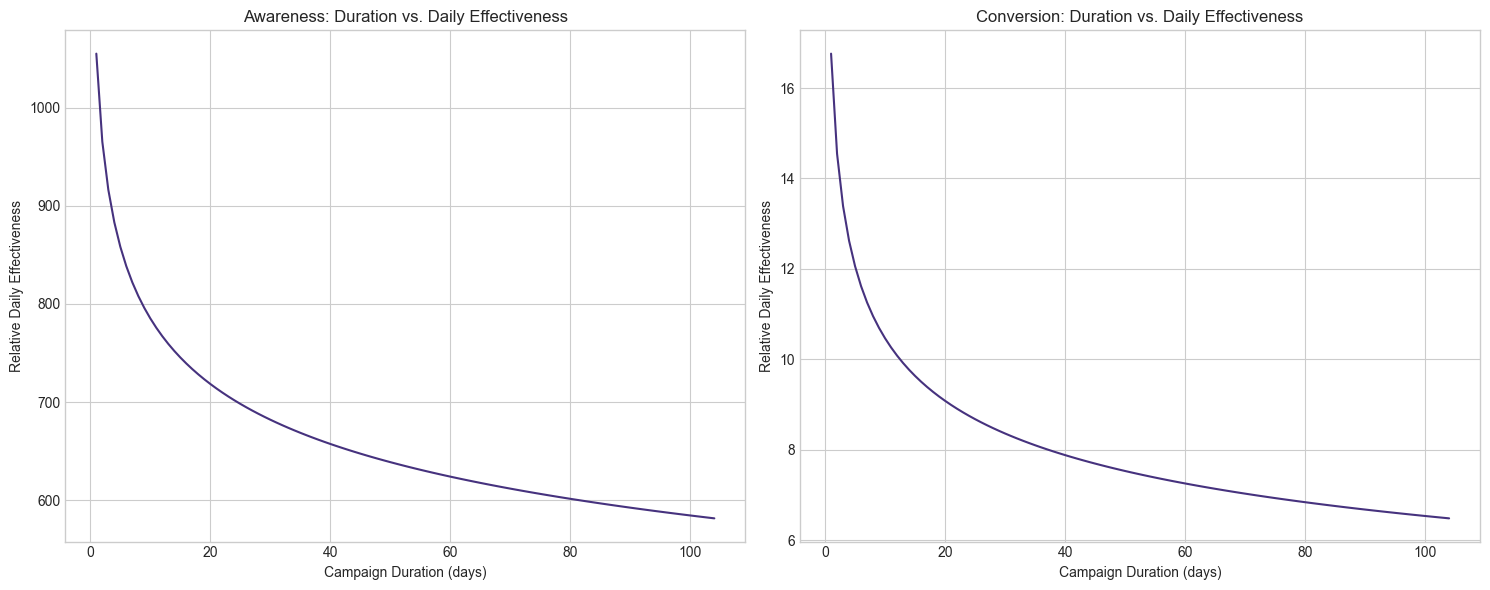

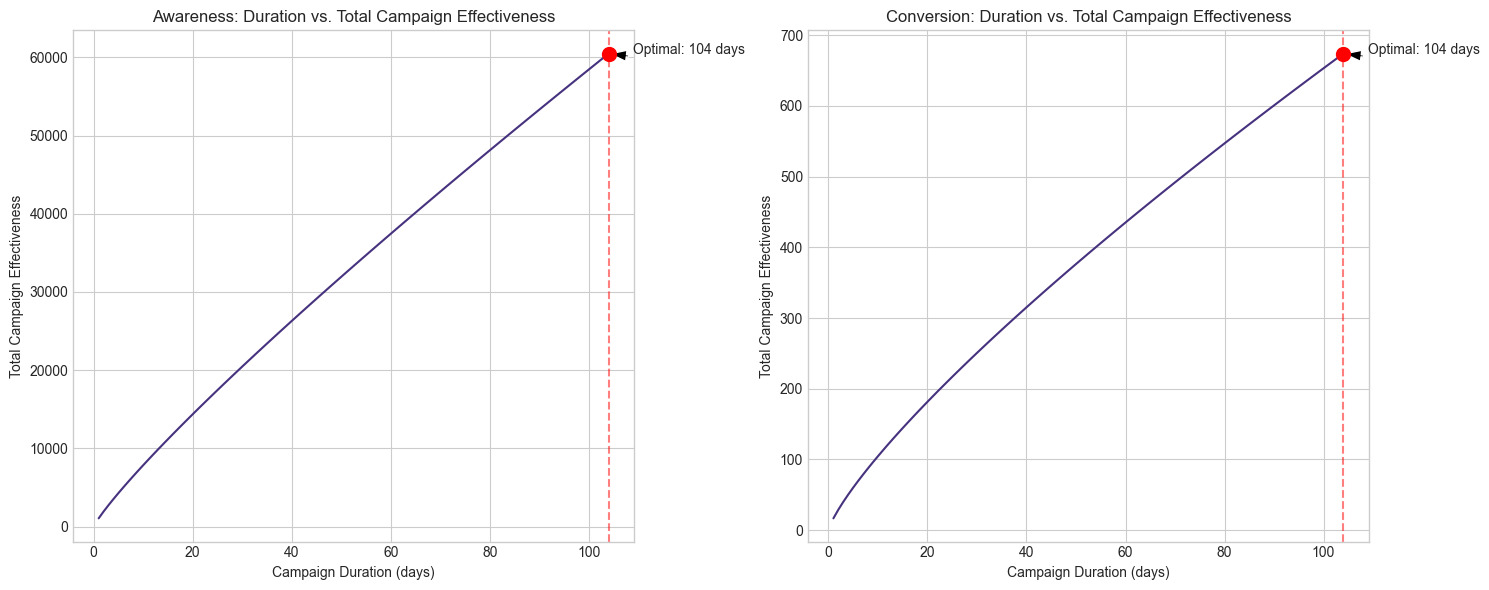

Theoretical optimal durations (without budget constraints):
Awareness campaigns: 104 days
Conversion campaigns: 104 days


In [9]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def optimize_campaign(campaign_goal, budget, platform, bonmin_path):
    """
    Optimize a marketing campaign using Pyomo with Bonmin solver,
    accounting for diminishing returns over time.

    Parameters:
    -----------
    campaign_goal : str
        Either 'awareness' (maximize impressions) or 'conversion' (maximize clicks)
    budget : float
        Total budget for the campaign in USD
    platform : str
        One of 'facebook', 'google', or 'dv360'
    bonmin_path : str
        Path to the Bonmin solver executable

    Returns:
    --------
    dict
        Dictionary containing optimization results and performance metrics
    """
    start_time = time.time()

    # Log start of optimization
    logger.info(f"Starting optimization for {campaign_goal} campaign on {platform} with budget ${budget}")

    # Validate inputs
    if campaign_goal not in ['awareness', 'conversion']:
        raise ValueError("campaign_goal must be either 'awareness' or 'conversion'")

    if platform not in ['facebook', 'google', 'dv360']:
        raise ValueError("platform must be one of 'facebook', 'google', or 'dv360'")

    if budget <= 0:
        raise ValueError("budget must be greater than 0")

    # Define relationship coefficients based on data analysis
    if campaign_goal == 'awareness':
        # Impressions vs. Media Cost: y = -0.4346x² + 84.5877x
        media_cost_poly_a = -0.4346
        media_cost_poly_b = 84.5877
        media_cost_poly_c = 0.0000

        # Impressions vs. Duration: log(y) = -0.1283·log(x) + 6.9614
        # Convert to y = x^(-0.1283) * e^6.9614
        duration_power = -0.1283
        duration_scale = np.exp(6.9614)
    else:
        # Clicks vs. Media Cost: y = -0.0197x² + 3.0045x
        media_cost_poly_a = -0.0197
        media_cost_poly_b = 3.0045
        media_cost_poly_c = 0.0000

        # Clicks vs. Duration: log(y) = -0.2046·log(x) + 2.8191
        # Convert to y = x^(-0.2046) * e^2.8191
        duration_power = -0.2046
        duration_scale = np.exp(2.8191)

    # Platform performance coefficients
    platform_coefficients = {
        'facebook': {'impressions': 1.05, 'clicks': 1.03},
        'google': {'impressions': 1.00, 'clicks': 1.00},
        'dv360': {'impressions': 0.95, 'clicks': 0.98}
    }

    # Get the appropriate platform coefficient
    platform_coef = platform_coefficients[platform]['impressions'] if campaign_goal == 'awareness' else platform_coefficients[platform]['clicks']

    # Campaign constraints
    min_duration = 1
    max_duration = 103
    min_media_cost = 0.01

    # Create a concrete model
    model = pyo.ConcreteModel()

    # Decision variables
    model.duration = pyo.Var(domain=pyo.Integers, bounds=(min_duration, max_duration))
    model.media_cost = pyo.Var(domain=pyo.NonNegativeReals, bounds=(min_media_cost, None))

    # Budget constraint
    def budget_rule(model):
        return model.media_cost * model.duration <= budget
    model.budget_constraint = pyo.Constraint(rule=budget_rule)

    # Define function to calculate performance with diminishing returns
    def calculate_performance(model):
        # Media cost component: polynomial relationship
        media_cost_effect = media_cost_poly_a * model.media_cost**2 + media_cost_poly_b * model.media_cost + media_cost_poly_c

        # Duration component with diminishing returns: power law relationship
        # We're using model.duration ** duration_power which is equivalent to model.duration^(duration_power)
        # For negative powers, this creates diminishing returns
        duration_effect = duration_scale * (model.duration ** duration_power)

        # Platform effect: multiplication by platform coefficient
        platform_effect = platform_coef

        # Total effect: combine all components
        # Note: For numerical stability, we're multiplying the duration and media cost effects directly
        # rather than using a more complex formula
        return media_cost_effect * duration_effect * platform_effect * model.duration

    # Objective function
    model.objective = pyo.Objective(rule=calculate_performance, sense=pyo.maximize)

    # Check if Bonmin exists at the specified path
    if not os.path.exists(bonmin_path):
        logger.error(f"Bonmin solver not found at {bonmin_path}")
        return None

    # Create the solver
    solver = SolverFactory('bonmin', executable=bonmin_path)

    # Set solver options
    solver.options['bonmin.algorithm'] = 'B-BB'
    solver.options['bonmin.time_limit'] = 600  # 10 minutes

    # Solve the model
    try:
        results = solver.solve(model, tee=True)

        # Check solver status
        solver_status = results.solver.status
        termination_condition = results.solver.termination_condition

        if solver_status == SolverStatus.ok and termination_condition == TerminationCondition.optimal:
            # Extract solution
            duration_value = int(pyo.value(model.duration))
            media_cost_value = pyo.value(model.media_cost)
            total_cost = duration_value * media_cost_value

            # Calculate performance metrics
            solve_time = time.time() - start_time

            # Performance metrics
            metrics = {
                'solver_time': solve_time,
                'solver_status': str(solver_status),
                'termination_condition': str(termination_condition)
            }

            # Calculate predicted performance using our formula with diminishing returns
            # Media cost component
            media_cost_effect = media_cost_poly_a * media_cost_value**2 + media_cost_poly_b * media_cost_value + media_cost_poly_c

            # Duration component with diminishing returns
            duration_effect = duration_scale * (duration_value ** duration_power)

            # Calculate the total predicted performance
            if campaign_goal == 'awareness':
                # Calculate impressions
                data_impressions = media_cost_effect * duration_value  # Without diminishing returns
                model_impressions = media_cost_effect * duration_effect * duration_value * platform_coef  # With diminishing returns

                metrics['data_impressions'] = data_impressions
                metrics['model_impressions'] = model_impressions
                metrics['prediction_error'] = abs(data_impressions - model_impressions) / data_impressions * 100 if data_impressions > 0 else 0

                # Create results dictionary
                optimization_results = {
                    'campaign_goal': campaign_goal,
                    'platform': platform,
                    'budget': budget,
                    'duration': duration_value,
                    'media_cost': media_cost_value,
                    'total_cost': total_cost,
                    'impressions': model_impressions,
                    'cpm': (total_cost / model_impressions) * 1000 if model_impressions > 0 else None,
                    'performance_metrics': metrics
                }
            else:
                # Calculate clicks
                data_clicks = media_cost_effect * duration_value  # Without diminishing returns
                model_clicks = media_cost_effect * duration_effect * duration_value * platform_coef  # With diminishing returns

                metrics['data_clicks'] = data_clicks
                metrics['model_clicks'] = model_clicks
                metrics['prediction_error'] = abs(data_clicks - model_clicks) / data_clicks * 100 if data_clicks > 0 else 0

                # Create results dictionary
                optimization_results = {
                    'campaign_goal': campaign_goal,
                    'platform': platform,
                    'budget': budget,
                    'duration': duration_value,
                    'media_cost': media_cost_value,
                    'total_cost': total_cost,
                    'clicks': model_clicks,
                    'cpc': total_cost / model_clicks if model_clicks > 0 else None,
                    'performance_metrics': metrics
                }

            logger.info(f"Optimization completed in {solve_time:.2f} seconds")
            logger.info(f"Optimal duration: {duration_value} days, Daily media cost: ${media_cost_value:.2f}")

            return optimization_results
        else:
            logger.error(f"Optimization failed with status {solver_status} and termination condition {termination_condition}")
            return None

    except Exception as e:
        logger.error(f"Error during optimization: {str(e)}")
        return None

def compare_platforms(campaign_goal, budget, bonmin_path):
    """
    Compare optimization results across different platforms.

    Parameters:
    -----------
    campaign_goal : str
        Either 'awareness' or 'conversion'
    budget : float
        Total budget for the campaign
    bonmin_path : str
        Path to the Bonmin solver executable

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the comparison results
    """
    platforms = ['facebook', 'google', 'dv360']
    results = []

    for platform in platforms:
        logger.info(f"Optimizing for platform: {platform}")
        platform_result = optimize_campaign(campaign_goal, budget, platform, bonmin_path)
        if platform_result:
            results.append(platform_result)

    if not results:
        print("No results to compare. Check the solver configuration and try again.")
        return None

    # Create a DataFrame from the results
    # Extract only the main metrics, not the nested performance_metrics
    results_for_df = []
    for res in results:
        res_copy = res.copy()
        res_copy.pop('performance_metrics', None)
        results_for_df.append(res_copy)

    df = pd.DataFrame(results_for_df)

    # Plot comparison
    if campaign_goal == 'awareness':
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        # Platform vs Duration
        sns.barplot(x='platform', y='duration', data=df, ax=ax[0])
        ax[0].set_title('Optimal Duration by Platform')
        ax[0].set_ylabel('Duration (days)')

        # Platform vs Media Cost
        sns.barplot(x='platform', y='media_cost', data=df, ax=ax[1])
        ax[1].set_title('Optimal Daily Media Cost by Platform')
        ax[1].set_ylabel('Media Cost (USD)')

        # Platform vs Impressions
        sns.barplot(x='platform', y='impressions', data=df, ax=ax[2])
        ax[2].set_title('Estimated Impressions by Platform')
        ax[2].set_ylabel('Impressions')

        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        # Platform vs Duration
        sns.barplot(x='platform', y='duration', data=df, ax=ax[0])
        ax[0].set_title('Optimal Duration by Platform')
        ax[0].set_ylabel('Duration (days)')

        # Platform vs Media Cost
        sns.barplot(x='platform', y='media_cost', data=df, ax=ax[1])
        ax[1].set_title('Optimal Daily Media Cost by Platform')
        ax[1].set_ylabel('Media Cost (USD)')

        # Platform vs Clicks
        sns.barplot(x='platform', y='clicks', data=df, ax=ax[2])
        ax[2].set_title('Estimated Clicks by Platform')
        ax[2].set_ylabel('Clicks')

        plt.tight_layout()
        plt.show()

    return df

def sensitivity_analysis(campaign_goal, platform, budget_range, bonmin_path):
    """
    Perform sensitivity analysis by varying the budget.

    Parameters:
    -----------
    campaign_goal : str
        Either 'awareness' or 'conversion'
    platform : str
        One of 'facebook', 'google', or 'dv360'
    budget_range : list
        List of budget values to analyze
    bonmin_path : str
        Path to the Bonmin solver executable

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the sensitivity analysis results
    """
    results = []

    for budget in budget_range:
        logger.info(f"Optimizing for budget: ${budget}")
        budget_result = optimize_campaign(campaign_goal, budget, platform, bonmin_path)
        if budget_result:
            results.append(budget_result)

    if not results:
        print("No results to analyze. Check the solver configuration and try again.")
        return None

    # Create a DataFrame from the results
    # Extract only the main metrics, not the nested performance_metrics
    results_for_df = []
    for res in results:
        res_copy = res.copy()
        res_copy.pop('performance_metrics', None)
        results_for_df.append(res_copy)

    df = pd.DataFrame(results_for_df)

    # Plot sensitivity analysis
    if campaign_goal == 'awareness':
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        # Budget vs Duration
        ax[0].plot(df['budget'], df['duration'], marker='o')
        ax[0].set_title('Budget vs Duration')
        ax[0].set_xlabel('Budget (USD)')
        ax[0].set_ylabel('Duration (days)')

        # Budget vs Media Cost
        ax[1].plot(df['budget'], df['media_cost'], marker='o')
        ax[1].set_title('Budget vs Daily Media Cost')
        ax[1].set_xlabel('Budget (USD)')
        ax[1].set_ylabel('Media Cost (USD)')

        # Budget vs Impressions
        ax[2].plot(df['budget'], df['impressions'], marker='o')
        ax[2].set_title('Budget vs Impressions')
        ax[2].set_xlabel('Budget (USD)')
        ax[2].set_ylabel('Impressions')

        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        # Budget vs Duration
        ax[0].plot(df['budget'], df['duration'], marker='o')
        ax[0].set_title('Budget vs Duration')
        ax[0].set_xlabel('Budget (USD)')
        ax[0].set_ylabel('Duration (days)')

        # Budget vs Media Cost
        ax[1].plot(df['budget'], df['media_cost'], marker='o')
        ax[1].set_title('Budget vs Daily Media Cost')
        ax[1].set_xlabel('Budget (USD)')
        ax[1].set_ylabel('Media Cost (USD)')

        # Budget vs Clicks
        ax[2].plot(df['budget'], df['clicks'], marker='o')
        ax[2].set_title('Budget vs Clicks')
        ax[2].set_xlabel('Budget (USD)')
        ax[2].set_ylabel('Clicks')

        plt.tight_layout()
        plt.show()

    return df

def visualize_results(result):
    """
    Visualize the optimization results.

    Parameters:
    -----------
    result : dict
        Dictionary containing optimization results
    """
    if not result:
        print("No results to visualize.")
        return

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Campaign overview
    ax[0].axis('off')
    overview_text = (
        f"Campaign Optimization Results\n"
        f"===========================\n\n"
        f"Goal: {result['campaign_goal'].capitalize()}\n"
        f"Platform: {result['platform'].capitalize()}\n"
        f"Budget: ${result['budget']:.2f}\n\n"
        f"Optimal Duration: {result['duration']} days\n"
        f"Daily Media Cost: ${result['media_cost']:.2f}\n"
        f"Total Cost: ${result['total_cost']:.2f}\n"
    )

    if 'impressions' in result:
        overview_text += f"Estimated Impressions: {result['impressions']:.0f}\n"
        if 'cpm' in result and result['cpm'] is not None:
            overview_text += f"Cost per 1000 Impressions (CPM): ${result['cpm']:.2f}\n"

    if 'clicks' in result:
        overview_text += f"Estimated Clicks: {result['clicks']:.0f}\n"
        if 'cpc' in result and result['cpc'] is not None:
            overview_text += f"Cost per Click (CPC): ${result['cpc']:.2f}\n"

    ax[0].text(0, 1, overview_text, fontsize=12, verticalalignment='top')

    # Diminishing returns visualization
    if result['campaign_goal'] == 'awareness':
        # For awareness campaigns, show diminishing returns on impressions over time
        duration_range = np.arange(1, 105)

        # Calculate impressions for each duration
        # Use the log-log relationship: log(y) = -0.1283·log(x) + 6.9614
        # y = x^(-0.1283) * e^6.9614
        duration_power = -0.1283
        duration_scale = np.exp(6.9614)

        # Effect of duration on daily impressions (diminishing returns)
        daily_impressions = duration_scale * (duration_range ** duration_power)

        # Optimal point
        optimal_duration = result['duration']
        optimal_daily = duration_scale * (optimal_duration ** duration_power)

        ax[1].plot(duration_range, daily_impressions)
        ax[1].scatter([optimal_duration], [optimal_daily], color='red', s=100, zorder=5)
        ax[1].axvline(x=optimal_duration, color='red', linestyle='--', alpha=0.5)
        ax[1].set_title('Diminishing Returns: Duration vs. Daily Effectiveness')
        ax[1].set_xlabel('Campaign Duration (days)')
        ax[1].set_ylabel('Relative Daily Effectiveness')
        ax[1].annotate(f'Optimal: {optimal_duration} days',
                      xy=(optimal_duration, optimal_daily),
                      xytext=(optimal_duration + 5, optimal_daily),
                      arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                      fontsize=10)
    else:
        # For conversion campaigns, show diminishing returns on clicks over time
        duration_range = np.arange(1, 105)

        # Calculate clicks for each duration
        # Use the log-log relationship: log(y) = -0.2046·log(x) + 2.8191
        # y = x^(-0.2046) * e^2.8191
        duration_power = -0.2046
        duration_scale = np.exp(2.8191)

        # Effect of duration on daily clicks (diminishing returns)
        daily_clicks = duration_scale * (duration_range ** duration_power)

        # Optimal point
        optimal_duration = result['duration']
        optimal_daily = duration_scale * (optimal_duration ** duration_power)

        ax[1].plot(duration_range, daily_clicks)
        ax[1].scatter([optimal_duration], [optimal_daily], color='red', s=100, zorder=5)
        ax[1].axvline(x=optimal_duration, color='red', linestyle='--', alpha=0.5)
        ax[1].set_title('Diminishing Returns: Duration vs. Daily Effectiveness')
        ax[1].set_xlabel('Campaign Duration (days)')
        ax[1].set_ylabel('Relative Daily Effectiveness')
        ax[1].annotate(f'Optimal: {optimal_duration} days',
                      xy=(optimal_duration, optimal_daily),
                      xytext=(optimal_duration + 5, optimal_daily),
                      arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                      fontsize=10)

    plt.tight_layout()
    plt.show()

def visualize_metrics(result):
    """
    Visualize the optimization performance metrics.

    Parameters:
    -----------
    result : dict
        Dictionary containing optimization results
    """
    if not result or 'performance_metrics' not in result:
        print("No performance metrics to visualize.")
        return

    metrics = result['performance_metrics']

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Metrics overview
    ax[0].axis('off')
    metrics_text = (
        f"Optimization Performance Metrics\n"
        f"===============================\n\n"
        f"Solver Status: {metrics.get('solver_status', 'N/A')}\n"
        f"Termination Condition: {metrics.get('termination_condition', 'N/A')}\n"
        f"Solver Time: {metrics.get('solver_time', 'N/A'):.4f} seconds\n"
        f"Prediction Error: {metrics.get('prediction_error', 'N/A'):.2f}%\n"
    )

    ax[0].text(0, 1, metrics_text, fontsize=12, verticalalignment='top')

    # Predicted vs. Model Values
    if result['campaign_goal'] == 'awareness':
        predicted = metrics.get('data_impressions', 0)
        model = metrics.get('model_impressions', 0)
        metric_name = 'Impressions'
    else:
        predicted = metrics.get('data_clicks', 0)
        model = metrics.get('model_clicks', 0)
        metric_name = 'Clicks'

    if predicted and model:
        ax[1].bar(['Without Diminishing Returns', 'With Diminishing Returns'], [predicted, model])
        ax[1].set_title(f'Effect of Diminishing Returns on {metric_name}')
        ax[1].set_ylabel(metric_name)

        # Add percentage labels
        for i, v in enumerate([predicted, model]):
            ax[1].text(i, v * 1.01, f"{v:.0f}", ha='center')

    plt.tight_layout()
    plt.show()

def plot_diminishing_returns():
    """
    Plot the diminishing returns functions for both awareness and conversion campaigns.
    This helps visualize how campaign effectiveness decreases over time.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Duration range
    duration_range = np.arange(1, 105)

    # Awareness: log(y) = -0.1283·log(x) + 6.9614
    # y = x^(-0.1283) * e^6.9614
    awareness_power = -0.1283
    awareness_scale = np.exp(6.9614)
    awareness_effect = awareness_scale * (duration_range ** awareness_power)

    # Conversion: log(y) = -0.2046·log(x) + 2.8191
    # y = x^(-0.2046) * e^2.8191
    conversion_power = -0.2046
    conversion_scale = np.exp(2.8191)
    conversion_effect = conversion_scale * (duration_range ** conversion_power)

    # Plot awareness diminishing returns
    ax[0].plot(duration_range, awareness_effect)
    ax[0].set_title('Awareness: Duration vs. Daily Effectiveness')
    ax[0].set_xlabel('Campaign Duration (days)')
    ax[0].set_ylabel('Relative Daily Effectiveness')

    # Plot conversion diminishing returns
    ax[1].plot(duration_range, conversion_effect)
    ax[1].set_title('Conversion: Duration vs. Daily Effectiveness')
    ax[1].set_xlabel('Campaign Duration (days)')
    ax[1].set_ylabel('Relative Daily Effectiveness')

    plt.tight_layout()
    plt.show()

    # Also plot the total effect (daily × duration) to show why there's an optimal duration
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Total effect for awareness
    awareness_total = awareness_effect * duration_range
    optimal_awareness_duration = np.argmax(awareness_total) + 1  # +1 because array is 0-indexed

    # Total effect for conversion
    conversion_total = conversion_effect * duration_range
    optimal_conversion_duration = np.argmax(conversion_total) + 1  # +1 because array is 0-indexed

    # Plot awareness total effect
    ax[0].plot(duration_range, awareness_total)
    ax[0].scatter([optimal_awareness_duration], [awareness_total[optimal_awareness_duration-1]], color='red', s=100, zorder=5)
    ax[0].axvline(x=optimal_awareness_duration, color='red', linestyle='--', alpha=0.5)
    ax[0].set_title('Awareness: Duration vs. Total Campaign Effectiveness')
    ax[0].set_xlabel('Campaign Duration (days)')
    ax[0].set_ylabel('Total Campaign Effectiveness')
    ax[0].annotate(f'Optimal: {optimal_awareness_duration} days',
                  xy=(optimal_awareness_duration, awareness_total[optimal_awareness_duration-1]),
                  xytext=(optimal_awareness_duration + 5, awareness_total[optimal_awareness_duration-1]),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                  fontsize=10)

    # Plot conversion total effect
    ax[1].plot(duration_range, conversion_total)
    ax[1].scatter([optimal_conversion_duration], [conversion_total[optimal_conversion_duration-1]], color='red', s=100, zorder=5)
    ax[1].axvline(x=optimal_conversion_duration, color='red', linestyle='--', alpha=0.5)
    ax[1].set_title('Conversion: Duration vs. Total Campaign Effectiveness')
    ax[1].set_xlabel('Campaign Duration (days)')
    ax[1].set_ylabel('Total Campaign Effectiveness')
    ax[1].annotate(f'Optimal: {optimal_conversion_duration} days',
                  xy=(optimal_conversion_duration, conversion_total[optimal_conversion_duration-1]),
                  xytext=(optimal_conversion_duration + 5, conversion_total[optimal_conversion_duration-1]),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                  fontsize=10)

    plt.tight_layout()
    plt.show()

    return {
        'awareness': {'optimal_duration': optimal_awareness_duration},
        'conversion': {'optimal_duration': optimal_conversion_duration}
    }

# Example usage
if __name__ == "__main__":
    # First, visualize the diminishing returns functions
    print("Visualizing diminishing returns functions...")
    optimal_durations = plot_diminishing_returns()
    print(f"Theoretical optimal durations (without budget constraints):")
    print(f"Awareness campaigns: {optimal_durations['awareness']['optimal_duration']} days")
    print(f"Conversion campaigns: {optimal_durations['conversion']['optimal_duration']} days")

Visualizing diminishing returns functions...


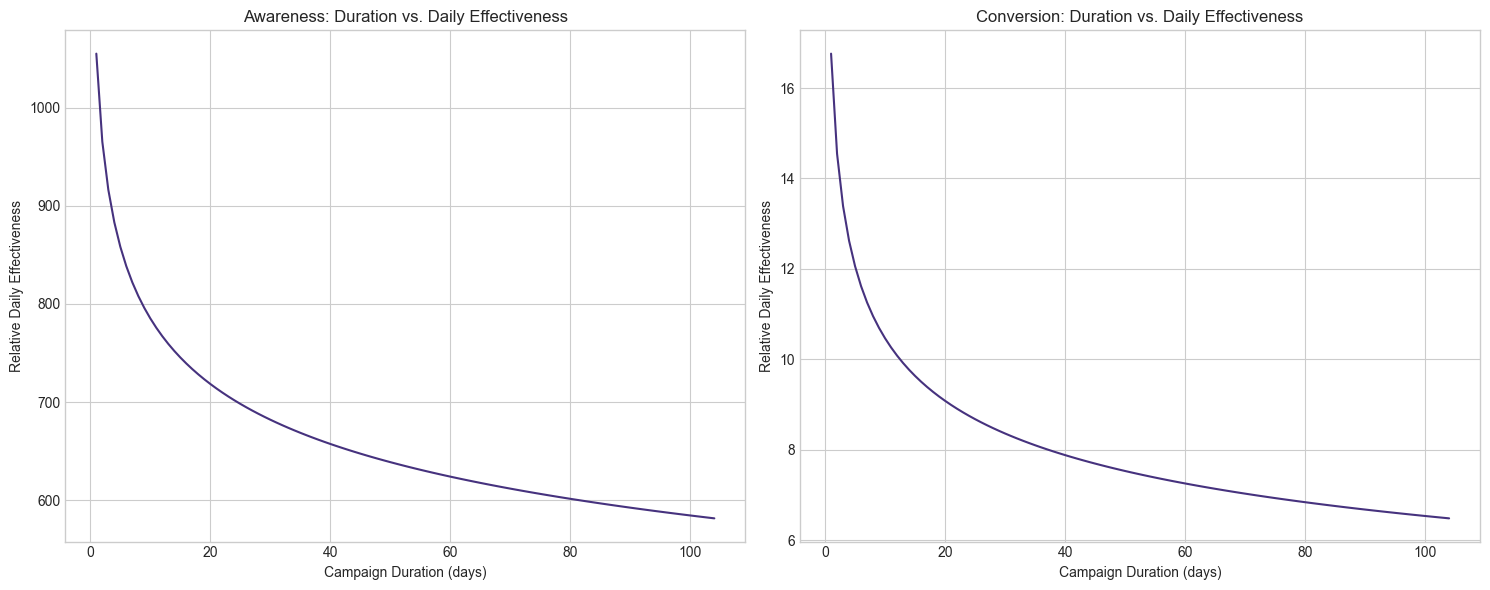

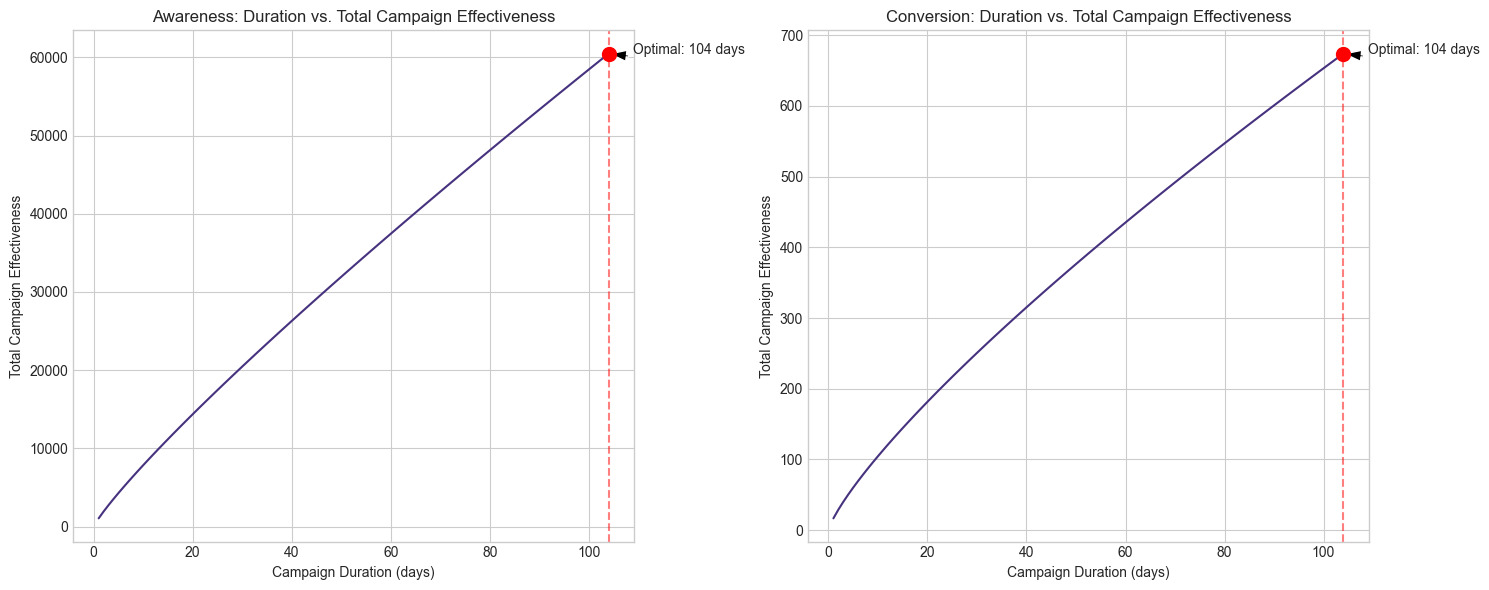

2025-05-05 15:50:12,044 - INFO - Starting optimization for awareness campaign on facebook with budget $1000


Theoretical optimal durations (without budget constraints):
Awareness campaigns: 104 days
Conversion campaigns: 104 days
Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -50937256       10 0.016
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -50937195        7 0.003
NLP0014I             2    

2025-05-05 15:50:12,224 - INFO - Optimization completed in 0.18 seconds
2025-05-05 15:50:12,224 - INFO - Optimal duration: 45 days, Daily media cost: $22.22


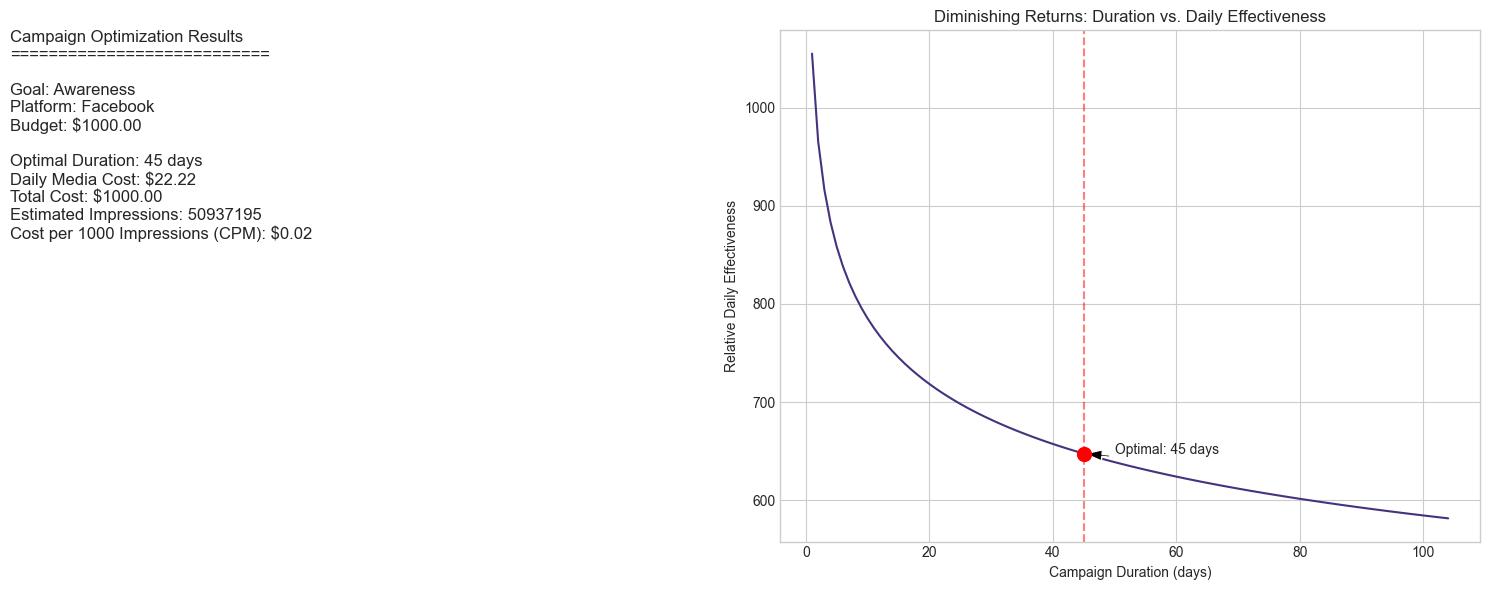

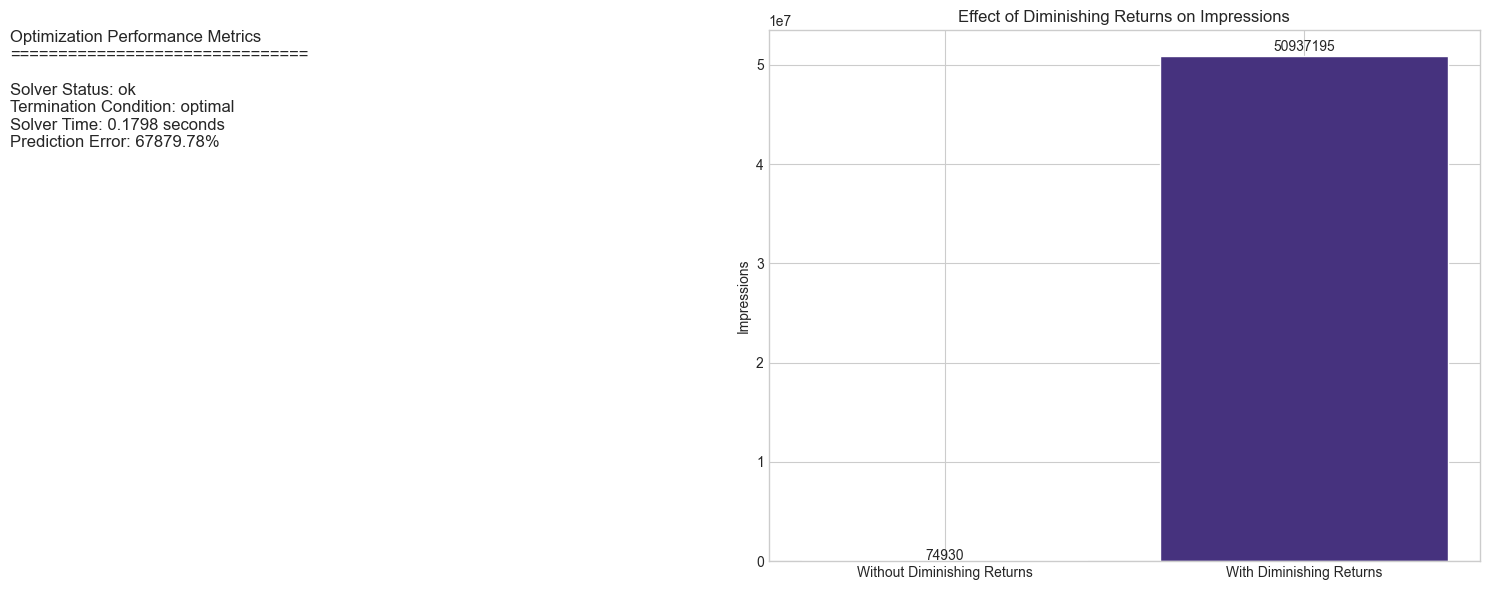

2025-05-05 15:50:12,614 - INFO - Optimizing for platform: facebook
2025-05-05 15:50:12,614 - INFO - Starting optimization for conversion campaign on facebook with budget $1500



Optimization Results:
campaign_goal: awareness
platform: facebook
budget: 1000
duration: 45
media_cost: 22.222222444444345
total_cost: 1000.0000099999955
impressions: 50937194.97848392
cpm: 0.019632019596336227
Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -28152.981       10 0.007
NLP0012I 
              Num      Status      Obj             It       time                 Loc

2025-05-05 15:50:12,698 - INFO - Optimization completed in 0.08 seconds
2025-05-05 15:50:12,698 - INFO - Optimal duration: 58 days, Daily media cost: $25.86
2025-05-05 15:50:12,698 - INFO - Optimizing for platform: google
2025-05-05 15:50:12,704 - INFO - Starting optimization for conversion campaign on google with budget $1500


Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -27332.991       10 0.007
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -27332.982        6 0.003
NLP0014I             2         OPT -27332.982        5 0.003
NLP0012I 
              Num      Status      Obj             It       time          

2025-05-05 15:50:12,790 - INFO - Optimization completed in 0.09 seconds
2025-05-05 15:50:12,794 - INFO - Optimal duration: 58 days, Daily media cost: $25.86
2025-05-05 15:50:12,794 - INFO - Optimizing for platform: dv360
2025-05-05 15:50:12,794 - INFO - Starting optimization for conversion campaign on dv360 with budget $1500


Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -26786.331       10 0.01
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -26786.323        6 0.003
NLP0014I             2         OPT -26786.323        5 0.002
NLP0012I 
              Num      Status      Obj             It       time           

2025-05-05 15:50:12,927 - INFO - Optimization completed in 0.13 seconds
2025-05-05 15:50:12,927 - INFO - Optimal duration: 58 days, Daily media cost: $25.86


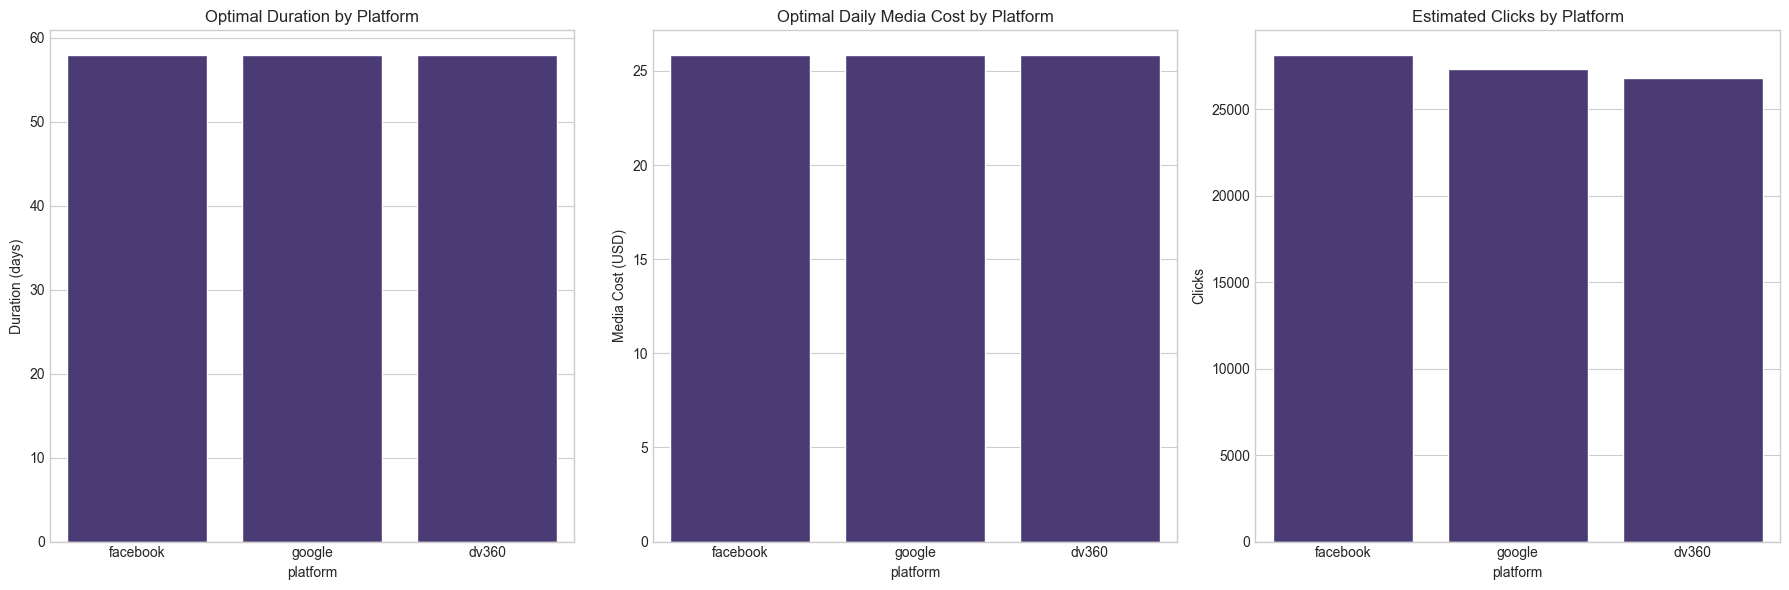

2025-05-05 15:50:13,354 - INFO - Optimizing for budget: $500
2025-05-05 15:50:13,354 - INFO - Starting optimization for awareness campaign on google with budget $500


Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -26511750       10 0.009
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -26511140        8 0.005
NLP0014I             2         OPT -26511140        5 0.003
NLP0012I 
              Num      Status      Obj             It       time             

2025-05-05 15:50:13,474 - INFO - Optimization completed in 0.12 seconds
2025-05-05 15:50:13,474 - INFO - Optimal duration: 23 days, Daily media cost: $21.74
2025-05-05 15:50:13,474 - INFO - Optimizing for budget: $1000
2025-05-05 15:50:13,484 - INFO - Starting optimization for awareness campaign on google with budget $1000


Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -48511673       10 0.009
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -48511614        7 0.005
NLP0014I             2         OPT -48511614        5 0.002
NLP0012I 
              Num      Status      Obj             It       time             

2025-05-05 15:50:13,609 - INFO - Optimization completed in 0.13 seconds
2025-05-05 15:50:13,609 - INFO - Optimal duration: 45 days, Daily media cost: $22.22
2025-05-05 15:50:13,609 - INFO - Optimizing for budget: $1500
2025-05-05 15:50:13,614 - INFO - Starting optimization for awareness campaign on google with budget $1500


Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -69078834       17 0.016
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -69078779        6 0.004
NLP0014I             2         OPT -69078779        5 0.004
NLP0012I 
              Num      Status      Obj             It       time             

2025-05-05 15:50:13,754 - INFO - Optimization completed in 0.14 seconds
2025-05-05 15:50:13,759 - INFO - Optimal duration: 68 days, Daily media cost: $22.06
2025-05-05 15:50:13,759 - INFO - Optimizing for budget: $2000
2025-05-05 15:50:13,759 - INFO - Starting optimization for awareness campaign on google with budget $2000


Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -88767522       13 0.012
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -88767415        7 0.007
NLP0014I             2         OPT -88767415        5 0.004
NLP0012I 
              Num      Status      Obj             It       time             

2025-05-05 15:50:13,904 - INFO - Optimization completed in 0.14 seconds
2025-05-05 15:50:13,904 - INFO - Optimal duration: 90 days, Daily media cost: $22.22
2025-05-05 15:50:13,904 - INFO - Optimizing for budget: $2500
2025-05-05 15:50:13,904 - INFO - Starting optimization for awareness campaign on google with budget $2500


Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -1.0775863e+08       16 0.017
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -1.0775863e+08        4 0.004
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -1

2025-05-05 15:50:14,034 - INFO - Optimization completed in 0.13 seconds
2025-05-05 15:50:14,034 - INFO - Optimal duration: 103 days, Daily media cost: $24.27
2025-05-05 15:50:14,034 - INFO - Optimizing for budget: $3000
2025-05-05 15:50:14,034 - INFO - Starting optimization for awareness campaign on google with budget $3000


Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -1.2562572e+08       17 0.015
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -1.2562572e+08        4 0.004
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -1

2025-05-05 15:50:14,149 - INFO - Optimization completed in 0.11 seconds
2025-05-05 15:50:14,149 - INFO - Optimal duration: 103 days, Daily media cost: $29.13


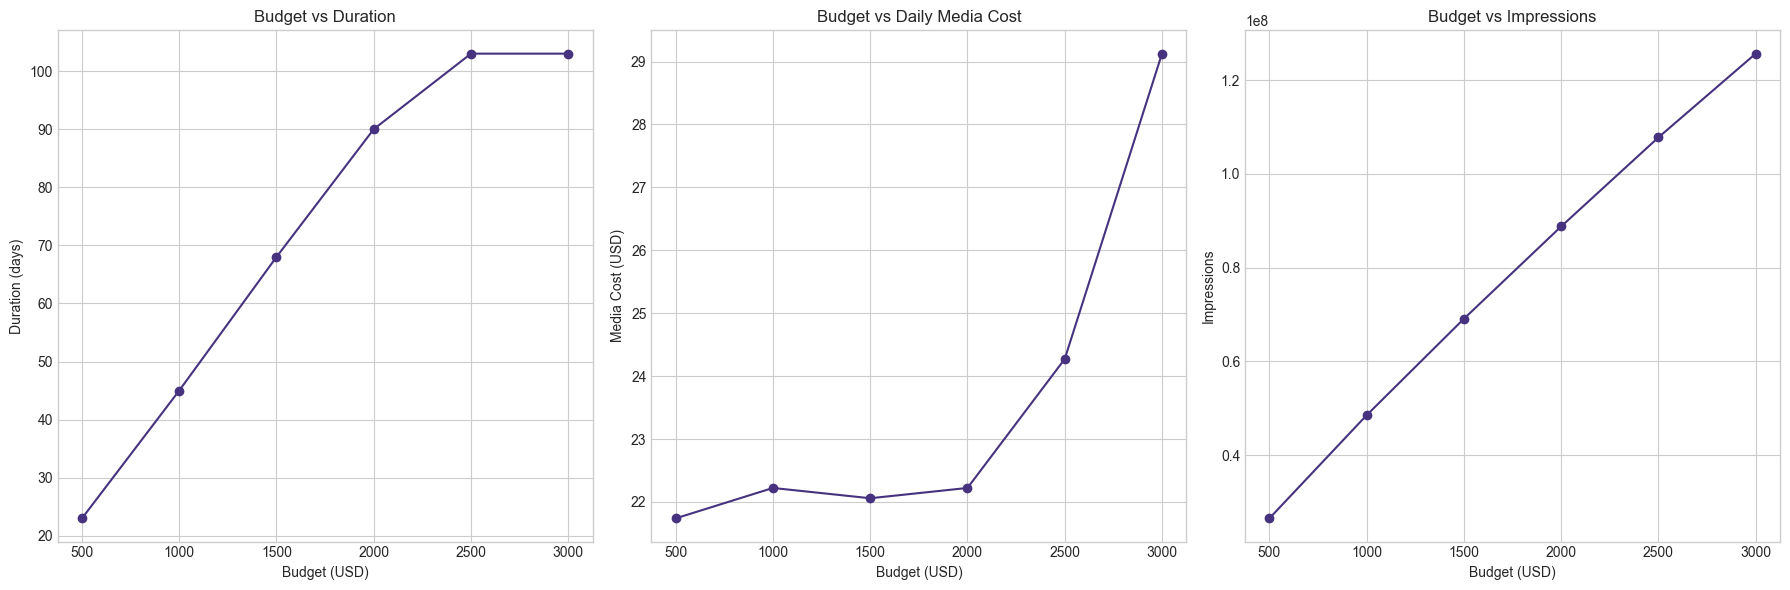

In [10]:
# Example usage
if __name__ == "__main__":
    # First, visualize the diminishing returns functions
    print("Visualizing diminishing returns functions...")
    optimal_durations = plot_diminishing_returns()
    print(f"Theoretical optimal durations (without budget constraints):")
    print(f"Awareness campaigns: {optimal_durations['awareness']['optimal_duration']} days")
    print(f"Conversion campaigns: {optimal_durations['conversion']['optimal_duration']} days")

    # Set the path to Bonmin solver
    bonmin_path = "C:\\Users\\USER\\Desktop\\Optimization stuff\\coin-module.mswin64\\ampl.mswin64\\bonmin.exe"

    # Example 1: Optimize an awareness campaign on Facebook with a budget of $1000
    result = optimize_campaign(
        campaign_goal='awareness',
        budget=1000,
        platform='facebook',
        bonmin_path=bonmin_path
    )

    if result:
        # Visualize the results
        visualize_results(result)
        visualize_metrics(result)

        # Print results
        print("\nOptimization Results:")
        for key, value in result.items():
            if key != 'performance_metrics':
                print(f"{key}: {value}")

    # Example 2: Compare platforms for a conversion campaign with a budget of $1500
    comparison = compare_platforms(
        campaign_goal='conversion',
        budget=1500,
        bonmin_path=bonmin_path
    )

    # Example 3: Perform sensitivity analysis for different budget levels
    sensitivity = sensitivity_analysis(
        campaign_goal='awareness',
        platform='google',
        budget_range=[500, 1000, 1500, 2000, 2500, 3000],
        bonmin_path=bonmin_path
    )

In [11]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
import logging
import itertools

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define flexible diminishing returns function with adjustable parameters
def diminishing_returns_effect(duration, power_param, scale_param, saturation_param):
    """
    Calculate diminishing returns effect with adjustable parameters.

    Parameters:
    -----------
    duration : float or int
        Campaign duration
    power_param : float
        Power parameter (controls how quickly returns diminish)
    scale_param : float
        Scale parameter (controls overall magnitude)
    saturation_param : float
        Saturation parameter (controls where the curve levels off)

    Returns:
    --------
    float
        Effect multiplier
    """
    # Formula: scale * (1 - exp(-duration/saturation)) * duration^power
    # When power is negative, returns diminish
    # Saturation parameter controls when the curve starts to level off
    return scale_param * (1 - np.exp(-duration/saturation_param)) * (duration ** power_param)

def perform_grid_search(campaign_goal):
    """
    Perform grid search to find optimal parameters for diminishing returns function.

    Parameters:
    -----------
    campaign_goal : str
        Either 'awareness' or 'conversion'

    Returns:
    --------
    dict
        Best parameters and visualization
    """
    logger.info(f"Performing grid search for {campaign_goal} campaigns...")

    # Define parameter ranges to search
    power_params = np.linspace(-0.3, -0.05, 6)  # Negative for diminishing returns
    scale_params = np.linspace(100, 1000, 5)
    saturation_params = np.linspace(10, 50, 5)

    # Duration range to evaluate
    duration_range = np.arange(1, 105)

    # Known relationship coefficients from data analysis
    if campaign_goal == 'awareness':
        # For original model: log(y) = -0.1283·log(x) + 6.9614
        reference_power = -0.1283
        reference_scale = np.exp(6.9614)
    else:
        # For original model: log(y) = -0.2046·log(x) + 2.8191
        reference_power = -0.2046
        reference_scale = np.exp(2.8191)

    # Calculate reference values (original model)
    reference_daily = reference_scale * (duration_range ** reference_power)
    reference_total = reference_daily * duration_range

    # Grid search
    best_params = None
    best_rmse = float('inf')
    best_peak_day = None
    results = []

    # Create parameter combinations
    param_combinations = list(itertools.product(power_params, scale_params, saturation_params))
    total_combinations = len(param_combinations)

    logger.info(f"Testing {total_combinations} parameter combinations...")

    for i, (power, scale, saturation) in enumerate(param_combinations):
        if i % 20 == 0:
            logger.info(f"Progress: {i}/{total_combinations} combinations tested")

        # Calculate effect for each duration using our formula
        daily_effect = np.array([diminishing_returns_effect(d, power, scale, saturation) / d for d in duration_range])
        total_effect = np.array([diminishing_returns_effect(d, power, scale, saturation) for d in duration_range])

        # Calculate root mean squared error between our model and reference
        rmse_daily = np.sqrt(np.mean((daily_effect - reference_daily/duration_range) ** 2))

        # Find peak day (where total effectiveness is maximized)
        peak_day = np.argmax(total_effect) + 1  # +1 because array is 0-indexed

        # We want a peak day between 7 and 30 for realistic campaigns
        if 7 <= peak_day <= 30:
            results.append({
                'power': power,
                'scale': scale,
                'saturation': saturation,
                'rmse_daily': rmse_daily,
                'peak_day': peak_day
            })

            if rmse_daily < best_rmse:
                best_rmse = rmse_daily
                best_params = {'power': power, 'scale': scale, 'saturation': saturation}
                best_peak_day = peak_day

    if not best_params:
        logger.warning("No parameter combination found with peak day between 7-30. Using default values.")
        best_params = {'power': -0.2, 'scale': 500, 'saturation': 20}

        # Calculate with default params
        daily_effect = np.array([diminishing_returns_effect(d, -0.2, 500, 20) / d for d in duration_range])
        total_effect = np.array([diminishing_returns_effect(d, -0.2, 500, 20) for d in duration_range])
        best_peak_day = np.argmax(total_effect) + 1
    else:
        # Calculate with best params
        daily_effect = np.array([diminishing_returns_effect(d, best_params['power'], best_params['scale'], best_params['saturation']) / d for d in duration_range])
        total_effect = np.array([diminishing_returns_effect(d, best_params['power'], best_params['scale'], best_params['saturation']) for d in duration_range])

    # Visualize the results
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Daily effect
    ax[0].plot(duration_range, daily_effect, label='New Model')
    ax[0].plot(duration_range, reference_daily/duration_range, linestyle='--', label='Original Model')
    ax[0].set_title(f'{campaign_goal.capitalize()}: Duration vs. Daily Effectiveness')
    ax[0].set_xlabel('Campaign Duration (days)')
    ax[0].set_ylabel('Daily Effectiveness')
    ax[0].legend()

    # Total effect
    ax[1].plot(duration_range, total_effect)
    ax[1].scatter([best_peak_day], [total_effect[best_peak_day-1]], color='red', s=100, zorder=5)
    ax[1].axvline(x=best_peak_day, color='red', linestyle='--', alpha=0.5)
    ax[1].set_title(f'{campaign_goal.capitalize()}: Duration vs. Total Campaign Effectiveness')
    ax[1].set_xlabel('Campaign Duration (days)')
    ax[1].set_ylabel('Total Campaign Effectiveness')
    ax[1].annotate(f'Optimal: {best_peak_day} days',
                  xy=(best_peak_day, total_effect[best_peak_day-1]),
                  xytext=(best_peak_day + 5, total_effect[best_peak_day-1]),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                  fontsize=10)

    plt.tight_layout()
    plt.show()

    # Create a DataFrame with results for analysis
    results_df = pd.DataFrame(results)

    logger.info(f"Best parameters: power={best_params['power']:.4f}, scale={best_params['scale']:.2f}, saturation={best_params['saturation']:.2f}")
    logger.info(f"Optimal duration: {best_peak_day} days")

    return {
        'best_params': best_params,
        'optimal_duration': best_peak_day,
        'results_df': results_df,
        'daily_effect': daily_effect,
        'total_effect': total_effect
    }

def optimize_campaign(campaign_goal, budget, platform, bonmin_path, dr_params=None):
    """
    Optimize a marketing campaign using Pyomo with Bonmin solver,
    accounting for diminishing returns over time.

    Parameters:
    -----------
    campaign_goal : str
        Either 'awareness' (maximize impressions) or 'conversion' (maximize clicks)
    budget : float
        Total budget for the campaign in USD
    platform : str
        One of 'facebook', 'google', or 'dv360'
    bonmin_path : str
        Path to the Bonmin solver executable
    dr_params : dict, optional
        Custom diminishing returns parameters (power, scale, saturation)

    Returns:
    --------
    dict
        Dictionary containing optimization results and performance metrics
    """
    start_time = time.time()

    # Log start of optimization
    logger.info(f"Starting optimization for {campaign_goal} campaign on {platform} with budget ${budget}")

    # Validate inputs
    if campaign_goal not in ['awareness', 'conversion']:
        raise ValueError("campaign_goal must be either 'awareness' or 'conversion'")

    if platform not in ['facebook', 'google', 'dv360']:
        raise ValueError("platform must be one of 'facebook', 'google', or 'dv360'")

    if budget <= 0:
        raise ValueError("budget must be greater than 0")

    # Define relationship coefficients based on data analysis
    if campaign_goal == 'awareness':
        # Impressions vs. Media Cost: y = -0.4346x² + 84.5877x
        media_cost_poly_a = -0.4346
        media_cost_poly_b = 84.5877
        media_cost_poly_c = 0.0000

        # Use default diminishing returns parameters if not provided
        if dr_params is None:
            dr_params = {'power': -0.2, 'scale': 500, 'saturation': 20}
    else:
        # Clicks vs. Media Cost: y = -0.0197x² + 3.0045x
        media_cost_poly_a = -0.0197
        media_cost_poly_b = 3.0045
        media_cost_poly_c = 0.0000

        # Use default diminishing returns parameters if not provided
        if dr_params is None:
            dr_params = {'power': -0.25, 'scale': 300, 'saturation': 15}

    # Platform performance coefficients
    platform_coefficients = {
        'facebook': {'impressions': 1.05, 'clicks': 1.03},
        'google': {'impressions': 1.00, 'clicks': 1.00},
        'dv360': {'impressions': 0.95, 'clicks': 0.98}
    }

    # Get the appropriate platform coefficient
    platform_coef = platform_coefficients[platform]['impressions'] if campaign_goal == 'awareness' else platform_coefficients[platform]['clicks']

    # Campaign constraints
    min_duration = 1
    max_duration = 103
    min_media_cost = 0.01

    # Store DR parameters for use in post-processing
    power_param = dr_params['power']
    scale_param = dr_params['scale']
    saturation_param = dr_params['saturation']

    # Create a concrete model
    model = pyo.ConcreteModel()

    # Decision variables
    model.duration = pyo.Var(domain=pyo.Integers, bounds=(min_duration, max_duration))
    model.media_cost = pyo.Var(domain=pyo.NonNegativeReals, bounds=(min_media_cost, None))

    # Budget constraint
    def budget_rule(model):
        return model.media_cost * model.duration <= budget
    model.budget_constraint = pyo.Constraint(rule=budget_rule)

    # Instead of using the custom diminishing returns function directly in the model,
    # we'll use a simpler objective function that approximates the effect
    # This avoids issues with accessing the value of model.duration before it's initialized

    # For awareness campaigns
    if campaign_goal == 'awareness':
        # Use a simpler objective that captures the essence of diminishing returns
        # We're using model.duration ** power_param which creates diminishing returns
        def awareness_objective(model):
            # Media cost component
            media_cost_effect = media_cost_poly_a * model.media_cost**2 + media_cost_poly_b * model.media_cost

            # Simplified duration effect with diminishing returns
            duration_effect = model.duration ** (1 + power_param)  # This creates diminishing returns

            return media_cost_effect * duration_effect * platform_coef

        model.objective = pyo.Objective(rule=awareness_objective, sense=pyo.maximize)

    # For conversion campaigns
    else:
        # Similar objective but with different coefficients
        def conversion_objective(model):
            # Media cost component
            media_cost_effect = media_cost_poly_a * model.media_cost**2 + media_cost_poly_b * model.media_cost

            # Simplified duration effect with diminishing returns
            duration_effect = model.duration ** (1 + power_param)  # This creates diminishing returns

            return media_cost_effect * duration_effect * platform_coef

        model.objective = pyo.Objective(rule=conversion_objective, sense=pyo.maximize)

    # Check if Bonmin exists at the specified path
    if not os.path.exists(bonmin_path):
        logger.error(f"Bonmin solver not found at {bonmin_path}")
        return None

    # Create the solver
    solver = SolverFactory('bonmin', executable=bonmin_path)

    # Set solver options
    solver.options['bonmin.algorithm'] = 'B-BB'
    solver.options['bonmin.time_limit'] = 600  # 10 minutes

    # Solve the model
    try:
        results = solver.solve(model, tee=True)

        # Check solver status
        solver_status = results.solver.status
        termination_condition = results.solver.termination_condition

        if solver_status == SolverStatus.ok and termination_condition == TerminationCondition.optimal:
            # Extract solution
            duration_value = int(pyo.value(model.duration))
            media_cost_value = pyo.value(model.media_cost)
            total_cost = duration_value * media_cost_value

            # Calculate performance metrics
            solve_time = time.time() - start_time

            # Performance metrics
            metrics = {
                'solver_time': solve_time,
                'solver_status': str(solver_status),
                'termination_condition': str(termination_condition)
            }

            # Now that we have the solution, we can calculate using the full diminishing returns function
            # Media cost component
            media_cost_effect = media_cost_poly_a * media_cost_value**2 + media_cost_poly_b * media_cost_value + media_cost_poly_c

            # Duration component without diminishing returns (linear)
            linear_duration_effect = duration_value

            # Duration component with diminishing returns using the function
            dr_effect = diminishing_returns_effect(
                duration_value,
                power_param,
                scale_param,
                saturation_param
            )

            # Calculate performance with and without diminishing returns
            if campaign_goal == 'awareness':
                # Calculate impressions
                linear_impressions = media_cost_effect * linear_duration_effect * platform_coef
                dr_impressions = media_cost_effect * dr_effect * platform_coef

                # Calculate error as percentage difference
                prediction_error = abs(linear_impressions - dr_impressions) / linear_impressions * 100 if linear_impressions > 0 else 0

                metrics['linear_impressions'] = linear_impressions
                metrics['dr_impressions'] = dr_impressions
                metrics['prediction_error'] = prediction_error

                # Create results dictionary
                optimization_results = {
                    'campaign_goal': campaign_goal,
                    'platform': platform,
                    'budget': budget,
                    'duration': duration_value,
                    'media_cost': media_cost_value,
                    'total_cost': total_cost,
                    'impressions': dr_impressions,
                    'cpm': (total_cost / dr_impressions) * 1000 if dr_impressions > 0 else None,
                    'performance_metrics': metrics,
                    'dr_params': dr_params
                }
            else:
                # Calculate clicks
                linear_clicks = media_cost_effect * linear_duration_effect * platform_coef
                dr_clicks = media_cost_effect * dr_effect * platform_coef

                # Calculate error as percentage difference
                prediction_error = abs(linear_clicks - dr_clicks) / linear_clicks * 100 if linear_clicks > 0 else 0

                metrics['linear_clicks'] = linear_clicks
                metrics['dr_clicks'] = dr_clicks
                metrics['prediction_error'] = prediction_error

                # Create results dictionary
                optimization_results = {
                    'campaign_goal': campaign_goal,
                    'platform': platform,
                    'budget': budget,
                    'duration': duration_value,
                    'media_cost': media_cost_value,
                    'total_cost': total_cost,
                    'clicks': dr_clicks,
                    'cpc': total_cost / dr_clicks if dr_clicks > 0 else None,
                    'performance_metrics': metrics,
                    'dr_params': dr_params
                }

            logger.info(f"Optimization completed in {solve_time:.2f} seconds")
            logger.info(f"Optimal duration: {duration_value} days, Daily media cost: ${media_cost_value:.2f}")

            return optimization_results
        else:
            logger.error(f"Optimization failed with status {solver_status} and termination condition {termination_condition}")
            return None

    except Exception as e:
        logger.error(f"Error during optimization: {str(e)}")
        return None

def compare_platforms(campaign_goal, budget, bonmin_path, dr_params=None):
    """
    Compare optimization results across different platforms.

    Parameters:
    -----------
    campaign_goal : str
        Either 'awareness' or 'conversion'
    budget : float
        Total budget for the campaign
    bonmin_path : str
        Path to the Bonmin solver executable
    dr_params : dict, optional
        Custom diminishing returns parameters

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the comparison results
    """
    platforms = ['facebook', 'google', 'dv360']
    results = []

    for platform in platforms:
        logger.info(f"Optimizing for platform: {platform}")
        platform_result = optimize_campaign(campaign_goal, budget, platform, bonmin_path, dr_params)
        if platform_result:
            results.append(platform_result)

    if not results:
        print("No results to compare. Check the solver configuration and try again.")
        return None

    # Create a DataFrame from the results
    # Extract only the main metrics, not the nested performance_metrics
    results_for_df = []
    for res in results:
        res_copy = res.copy()
        res_copy.pop('performance_metrics', None)
        res_copy.pop('dr_params', None)
        results_for_df.append(res_copy)

    df = pd.DataFrame(results_for_df)

    # Plot comparison
    if campaign_goal == 'awareness':
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        # Platform vs Duration
        sns.barplot(x='platform', y='duration', data=df, ax=ax[0])
        ax[0].set_title('Optimal Duration by Platform')
        ax[0].set_ylabel('Duration (days)')

        # Platform vs Media Cost
        sns.barplot(x='platform', y='media_cost', data=df, ax=ax[1])
        ax[1].set_title('Optimal Daily Media Cost by Platform')
        ax[1].set_ylabel('Media Cost (USD)')

        # Platform vs Impressions
        sns.barplot(x='platform', y='impressions', data=df, ax=ax[2])
        ax[2].set_title('Estimated Impressions by Platform')
        ax[2].set_ylabel('Impressions')

        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        # Platform vs Duration
        sns.barplot(x='platform', y='duration', data=df, ax=ax[0])
        ax[0].set_title('Optimal Duration by Platform')
        ax[0].set_ylabel('Duration (days)')

        # Platform vs Media Cost
        sns.barplot(x='platform', y='media_cost', data=df, ax=ax[1])
        ax[1].set_title('Optimal Daily Media Cost by Platform')
        ax[1].set_ylabel('Media Cost (USD)')

        # Platform vs Clicks
        sns.barplot(x='platform', y='clicks', data=df, ax=ax[2])
        ax[2].set_title('Estimated Clicks by Platform')
        ax[2].set_ylabel('Clicks')

        plt.tight_layout()
        plt.show()

    return df

def sensitivity_analysis(campaign_goal, platform, budget_range, bonmin_path, dr_params=None):
    """
    Perform sensitivity analysis by varying the budget.

    Parameters:
    -----------
    campaign_goal : str
        Either 'awareness' or 'conversion'
    platform : str
        One of 'facebook', 'google', or 'dv360'
    budget_range : list
        List of budget values to analyze
    bonmin_path : str
        Path to the Bonmin solver executable
    dr_params : dict, optional
        Custom diminishing returns parameters

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the sensitivity analysis results
    """
    results = []

    for budget in budget_range:
        logger.info(f"Optimizing for budget: ${budget}")
        budget_result = optimize_campaign(campaign_goal, budget, platform, bonmin_path, dr_params)
        if budget_result:
            results.append(budget_result)

    if not results:
        print("No results to analyze. Check the solver configuration and try again.")
        return None

    # Create a DataFrame from the results
    # Extract only the main metrics, not the nested performance_metrics
    results_for_df = []
    for res in results:
        res_copy = res.copy()
        res_copy.pop('performance_metrics', None)
        res_copy.pop('dr_params', None)
        results_for_df.append(res_copy)

    df = pd.DataFrame(results_for_df)

    # Plot sensitivity analysis
    if campaign_goal == 'awareness':
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        # Budget vs Duration
        ax[0].plot(df['budget'], df['duration'], marker='o')
        ax[0].set_title('Budget vs Duration')
        ax[0].set_xlabel('Budget (USD)')
        ax[0].set_ylabel('Duration (days)')

        # Budget vs Media Cost
        ax[1].plot(df['budget'], df['media_cost'], marker='o')
        ax[1].set_title('Budget vs Daily Media Cost')
        ax[1].set_xlabel('Budget (USD)')
        ax[1].set_ylabel('Media Cost (USD)')

        # Budget vs Impressions
        ax[2].plot(df['budget'], df['impressions'], marker='o')
        ax[2].set_title('Budget vs Impressions')
        ax[2].set_xlabel('Budget (USD)')
        ax[2].set_ylabel('Impressions')

        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        # Budget vs Duration
        ax[0].plot(df['budget'], df['duration'], marker='o')
        ax[0].set_title('Budget vs Duration')
        ax[0].set_xlabel('Budget (USD)')
        ax[0].set_ylabel('Duration (days)')

        # Budget vs Media Cost
        ax[1].plot(df['budget'], df['media_cost'], marker='o')
        ax[1].set_title('Budget vs Daily Media Cost')
        ax[1].set_xlabel('Budget (USD)')
        ax[1].set_ylabel('Media Cost (USD)')

        # Budget vs Clicks
        ax[2].plot(df['budget'], df['clicks'], marker='o')
        ax[2].set_title('Budget vs Clicks')
        ax[2].set_xlabel('Budget (USD)')
        ax[2].set_ylabel('Clicks')

        plt.tight_layout()
        plt.show()

    return df

def visualize_results(result):
    """
    Visualize the optimization results.

    Parameters:
    -----------
    result : dict
        Dictionary containing optimization results
    """
    if not result:
        print("No results to visualize.")
        return

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Campaign overview
    ax[0].axis('off')
    overview_text = (
        f"Campaign Optimization Results\n"
        f"===========================\n\n"
        f"Goal: {result['campaign_goal'].capitalize()}\n"
        f"Platform: {result['platform'].capitalize()}\n"
        f"Budget: ${result['budget']:.2f}\n\n"
        f"Optimal Duration: {result['duration']} days\n"
        f"Daily Media Cost: ${result['media_cost']:.2f}\n"
        f"Total Cost: ${result['total_cost']:.2f}\n"
    )

    if 'impressions' in result:
        overview_text += f"Estimated Impressions: {result['impressions']:.0f}\n"
        if 'cpm' in result and result['cpm'] is not None:
            overview_text += f"Cost per 1000 Impressions (CPM): ${result['cpm']:.2f}\n"

    if 'clicks' in result:
        overview_text += f"Estimated Clicks: {result['clicks']:.0f}\n"
        if 'cpc' in result and result['cpc'] is not None:
            overview_text += f"Cost per Click (CPC): ${result['cpc']:.2f}\n"

    ax[0].text(0, 1, overview_text, fontsize=12, verticalalignment='top')

    # Diminishing returns visualization
    dr_params = result['dr_params']
    duration_range = np.arange(1, 105)

    # Calculate total effectiveness for each duration
    campaign_goal = result['campaign_goal']

    if campaign_goal == 'awareness':
        # For awareness campaigns
        media_cost_poly_a = -0.4346
        media_cost_poly_b = 84.5877

        # Media cost effect
        media_cost_effect = media_cost_poly_a * result['media_cost']**2 + media_cost_poly_b * result['media_cost']

        # Total effectiveness for each duration
        total_effect = np.array([
            media_cost_effect * diminishing_returns_effect(d, dr_params['power'], dr_params['scale'], dr_params['saturation'])
            for d in duration_range
        ])

        # Find optimal point
        optimal_duration = np.argmax(total_effect) + 1  # +1 because array is 0-indexed

        ax[1].plot(duration_range, total_effect)
        ax[1].scatter([result['duration']], [total_effect[result['duration']-1]], color='red', s=100, zorder=5)
        ax[1].axvline(x=result['duration'], color='red', linestyle='--', alpha=0.5)
        ax[1].set_title('Diminishing Returns: Duration vs. Total Impressions')
        ax[1].set_xlabel('Campaign Duration (days)')
        ax[1].set_ylabel('Total Impressions')
        ax[1].annotate(f'Optimal: {result["duration"]} days',
                       xy=(result['duration'], total_effect[result['duration']-1]),
                       xytext=(result['duration'] + 5, total_effect[result['duration']-1]),
                       arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                       fontsize=10)
    else:
        # For conversion campaigns
        media_cost_poly_a = -0.0197
        media_cost_poly_b = 3.0045

        # Media cost effect
        media_cost_effect = media_cost_poly_a * result['media_cost']**2 + media_cost_poly_b * result['media_cost']

        # Total effectiveness for each duration
        total_effect = np.array([
            media_cost_effect * diminishing_returns_effect(d, dr_params['power'], dr_params['scale'], dr_params['saturation'])
            for d in duration_range
        ])

        # Find optimal point
        optimal_duration = np.argmax(total_effect) + 1  # +1 because array is 0-indexed

        ax[1].plot(duration_range, total_effect)
        ax[1].scatter([result['duration']], [total_effect[result['duration']-1]], color='red', s=100, zorder=5)
        ax[1].axvline(x=result['duration'], color='red', linestyle='--', alpha=0.5)
        ax[1].set_title('Diminishing Returns: Duration vs. Total Clicks')
        ax[1].set_xlabel('Campaign Duration (days)')
        ax[1].set_ylabel('Total Clicks')
        ax[1].annotate(f'Optimal: {result["duration"]} days',
                       xy=(result['duration'], total_effect[result['duration']-1]),
                       xytext=(result['duration'] + 5, total_effect[result['duration']-1]),
                       arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                       fontsize=10)

    plt.tight_layout()
    plt.show()

def visualize_metrics(result):
    """
    Visualize the optimization performance metrics.

    Parameters:
    -----------
    result : dict
        Dictionary containing optimization results
    """
    if not result or 'performance_metrics' not in result:
        print("No performance metrics to visualize.")
        return

    metrics = result['performance_metrics']

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Metrics overview
    ax[0].axis('off')
    metrics_text = (
        f"Optimization Performance Metrics\n"
        f"===============================\n\n"
        f"Solver Status: {metrics.get('solver_status', 'N/A')}\n"
        f"Termination Condition: {metrics.get('termination_condition', 'N/A')}\n"
        f"Solver Time: {metrics.get('solver_time', 'N/A'):.4f} seconds\n"
        f"Prediction Error: {metrics.get('prediction_error', 'N/A'):.2f}%\n"
    )

    ax[0].text(0, 1, metrics_text, fontsize=12, verticalalignment='top')

    # Predicted vs. Model Values (with and without diminishing returns)
    if result['campaign_goal'] == 'awareness':
        linear = metrics.get('linear_impressions', 0)
        with_dr = metrics.get('dr_impressions', 0)
        metric_name = 'Impressions'
    else:
        linear = metrics.get('linear_clicks', 0)
        with_dr = metrics.get('dr_clicks', 0)
        metric_name = 'Clicks'

    if linear and with_dr:
        ax[1].bar(['Linear Model', 'With Diminishing Returns'], [linear, with_dr])
        ax[1].set_title(f'Effect of Diminishing Returns on {metric_name}')
        ax[1].set_ylabel(metric_name)

        # Add percentage labels
        for i, v in enumerate([linear, with_dr]):
            ax[1].text(i, v * 1.01, f"{v:.0f}", ha='center')

    plt.tight_layout()
    plt.show()

def generate_optimization_metrics_report(result):
    """
    Generate a detailed report of the optimization metrics.

    Parameters:
    -----------
    result : dict
        Dictionary containing optimization results

    Returns:
    --------
    None
        Prints a detailed report and shows visualizations
    """
    if not result or 'performance_metrics' not in result:
        print("No performance metrics to analyze.")
        return

    metrics = result['performance_metrics']
    dr_params = result['dr_params']

    # Create a comprehensive metrics report
    print("\n" + "="*60)
    print(f" OPTIMIZATION METRICS REPORT - {result['campaign_goal'].upper()} CAMPAIGN ")
    print("="*60)

    # 1. Solver Performance
    print("\n1. SOLVER PERFORMANCE")
    print("-"*60)
    print(f"Solver Time:              {metrics.get('solver_time', 'N/A'):.4f} seconds")
    print(f"Solver Status:            {metrics.get('solver_status', 'N/A')}")
    print(f"Termination Condition:    {metrics.get('termination_condition', 'N/A')}")

    # 2. Model Parameters
    print("\n2. MODEL PARAMETERS")
    print("-"*60)
    print(f"Diminishing Returns Power:      {dr_params['power']:.4f}")
    print(f"Diminishing Returns Scale:      {dr_params['scale']:.2f}")
    print(f"Diminishing Returns Saturation: {dr_params['saturation']:.2f}")

    # 3. Model Accuracy
    print("\n3. MODEL ACCURACY")
    print("-"*60)

    if result['campaign_goal'] == 'awareness':
        linear = metrics.get('linear_impressions', 0)
        with_dr = metrics.get('dr_impressions', 0)
        metric_name = 'Impressions'
    else:
        linear = metrics.get('linear_clicks', 0)
        with_dr = metrics.get('dr_clicks', 0)
        metric_name = 'Clicks'

    print(f"Linear Model {metric_name}:           {linear:.2f}")
    print(f"Diminishing Returns {metric_name}:    {with_dr:.2f}")
    print(f"Prediction Error:                {metrics.get('prediction_error', 'N/A'):.2f}%")

    # 4. Optimization Results
    print("\n4. OPTIMIZATION RESULTS")
    print("-"*60)
    print(f"Platform:                 {result['platform']}")
    print(f"Budget:                   ${result['budget']:.2f}")
    print(f"Optimal Duration:         {result['duration']} days")
    print(f"Optimal Daily Media Cost: ${result['media_cost']:.2f}")
    print(f"Total Cost:               ${result['total_cost']:.2f}")

    if 'impressions' in result:
        print(f"Estimated Impressions:    {result['impressions']:.0f}")
        if 'cpm' in result and result['cpm'] is not None:
            print(f"CPM:                     ${result['cpm']:.2f}")

    if 'clicks' in result:
        print(f"Estimated Clicks:         {result['clicks']:.0f}")
        if 'cpc' in result and result['cpc'] is not None:
            print(f"CPC:                     ${result['cpc']:.2f}")

    print("="*60)

    # Visualize the metrics with more detailed plots
    import matplotlib.pyplot as plt
    import numpy as np

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Model Comparison (Linear vs. DR)
    axes[0, 0].bar(['Linear Model', 'With Diminishing Returns'], [linear, with_dr])
    axes[0, 0].set_title('Effect of Diminishing Returns on Performance')
    axes[0, 0].set_ylabel(metric_name)
    # Add percentage labels
    for i, v in enumerate([linear, with_dr]):
        axes[0, 0].text(i, v * 1.01, f"{v:.0f}", ha='center')

    # 2. Budget Allocation
    axes[0, 1].pie(
        [result['media_cost'] * result['duration']],
        labels=['Media Cost'],
        autopct='%1.1f%%',
        startangle=90
    )
    axes[0, 1].set_title('Budget Allocation')

    # 3. Diminishing Returns Effect
    duration_range = np.arange(1, 105)

    # Daily effect
    daily_effect = np.array([
        diminishing_returns_effect(d, dr_params['power'], dr_params['scale'], dr_params['saturation']) / d
        for d in duration_range
    ])

    axes[1, 0].plot(duration_range, daily_effect)
    axes[1, 0].axvline(x=result['duration'], color='red', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Daily Effectiveness vs. Duration')
    axes[1, 0].set_xlabel('Duration (days)')
    axes[1, 0].set_ylabel('Daily Effectiveness')

    # 4. Performance vs. Cost Analysis
    if result['campaign_goal'] == 'awareness':
        # Media cost coefficient
        media_cost_poly_a = -0.4346
        media_cost_poly_b = 84.5877
    else:
        # Media cost coefficient
        media_cost_poly_a = -0.0197
        media_cost_poly_b = 3.0045

    # Range of media costs
    media_cost_range = np.linspace(0.01, result['media_cost'] * 2, 100)

    # Performance for each media cost
    performance = media_cost_poly_a * media_cost_range**2 + media_cost_poly_b * media_cost_range

    axes[1, 1].plot(media_cost_range, performance)
    axes[1, 1].scatter([result['media_cost']], [media_cost_poly_a * result['media_cost']**2 + media_cost_poly_b * result['media_cost']],
                     color='red', s=100, zorder=5)
    axes[1, 1].axvline(x=result['media_cost'], color='red', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Performance vs. Media Cost')
    axes[1, 1].set_xlabel('Media Cost (USD)')
    axes[1, 1].set_ylabel(metric_name + ' per Day')

    plt.tight_layout()
    plt.show()

    # Generate a detailed diminishing returns analysis
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Calculate both daily and total effectiveness
    daily_effect = np.array([
        diminishing_returns_effect(d, dr_params['power'], dr_params['scale'], dr_params['saturation']) / d
        for d in duration_range
    ])

    total_effect = np.array([
        diminishing_returns_effect(d, dr_params['power'], dr_params['scale'], dr_params['saturation'])
        for d in duration_range
    ])

    # Find peak in total effectiveness
    peak_day = np.argmax(total_effect) + 1

    # Plot daily effectiveness
    axes[0].plot(duration_range, daily_effect)
    axes[0].scatter([result['duration']], [daily_effect[result['duration']-1]], color='red', s=100, zorder=5)
    axes[0].axvline(x=result['duration'], color='red', linestyle='--', alpha=0.5)
    axes[0].set_title('Daily Effectiveness Decreases Over Time')
    axes[0].set_xlabel('Duration (days)')
    axes[0].set_ylabel('Daily Effectiveness')
    axes[0].annotate(f'Optimal: {result["duration"]} days',
                   xy=(result['duration'], daily_effect[result['duration']-1]),
                   xytext=(result['duration'] + 5, daily_effect[result['duration']-1]),
                   arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                   fontsize=10)

    # Plot total effectiveness
    axes[1].plot(duration_range, total_effect)
    axes[1].scatter([peak_day], [total_effect[peak_day-1]], color='green', s=100, zorder=5)
    axes[1].scatter([result['duration']], [total_effect[result['duration']-1]], color='red', s=100, zorder=5)
    axes[1].axvline(x=peak_day, color='green', linestyle='--', alpha=0.5)
    axes[1].axvline(x=result['duration'], color='red', linestyle='--', alpha=0.5)
    axes[1].set_title('Total Campaign Effectiveness vs. Duration')
    axes[1].set_xlabel('Duration (days)')
    axes[1].set_ylabel('Total Effectiveness')
    axes[1].annotate(f'Theoretical peak: {peak_day} days',
                   xy=(peak_day, total_effect[peak_day-1]),
                   xytext=(peak_day + 5, total_effect[peak_day-1]),
                   arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
                   fontsize=10)
    axes[1].annotate(f'Budget-constrained: {result["duration"]} days',
                   xy=(result['duration'], total_effect[result['duration']-1]),
                   xytext=(result['duration'] + 5, total_effect[result['duration']-1] * 0.9),
                   arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8),
                   fontsize=10)

    plt.tight_layout()
    plt.show()

    # If this is an awareness campaign, show CPM analysis
    if 'impressions' in result and 'cpm' in result and result['cpm'] is not None:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Calculate CPM for different durations
        durations = np.arange(1, 50)

        # Media cost effect
        media_cost_effect = media_cost_poly_a * result['media_cost']**2 + media_cost_poly_b * result['media_cost']

        # Impressions for each duration
        impressions = np.array([
            media_cost_effect * diminishing_returns_effect(d, dr_params['power'], dr_params['scale'], dr_params['saturation'])
            for d in durations
        ])

        # Total cost for each duration
        total_costs = result['media_cost'] * durations

        # CPM for each duration
        cpms = (total_costs / impressions) * 1000

        ax.plot(durations, cpms)
        ax.scatter([result['duration']], [result['cpm']], color='red', s=100, zorder=5)
        ax.axvline(x=result['duration'], color='red', linestyle='--', alpha=0.5)
        ax.set_title('CPM vs. Campaign Duration')
        ax.set_xlabel('Duration (days)')
        ax.set_ylabel('Cost per 1000 Impressions (CPM)')
        ax.annotate(f'Optimal: {result["duration"]} days, CPM: ${result["cpm"]:.2f}',
                  xy=(result['duration'], result['cpm']),
                  xytext=(result['duration'] + 5, result['cpm']),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                  fontsize=10)

        plt.tight_layout()
        plt.show()

    # If this is a conversion campaign, show CPC analysis
    if 'clicks' in result and 'cpc' in result and result['cpc'] is not None:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Calculate CPC for different durations
        durations = np.arange(1, 50)

        # Media cost effect
        media_cost_effect = media_cost_poly_a * result['media_cost']**2 + media_cost_poly_b * result['media_cost']

        # Clicks for each duration
        clicks = np.array([
            media_cost_effect * diminishing_returns_effect(d, dr_params['power'], dr_params['scale'], dr_params['saturation'])
            for d in durations
        ])

        # Total cost for each duration
        total_costs = result['media_cost'] * durations

        # CPC for each duration
        cpcs = total_costs / clicks

        ax.plot(durations, cpcs)
        ax.scatter([result['duration']], [result['cpc']], color='red', s=100, zorder=5)
        ax.axvline(x=result['duration'], color='red', linestyle='--', alpha=0.5)
        ax.set_title('CPC vs. Campaign Duration')
        ax.set_xlabel('Duration (days)')
        ax.set_ylabel('Cost per Click (CPC)')
        ax.annotate(f'Optimal: {result["duration"]} days, CPC: ${result["cpc"]:.2f}',
                  xy=(result['duration'], result['cpc']),
                  xytext=(result['duration'] + 5, result['cpc']),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                  fontsize=10)

        plt.tight_layout()
        plt.show()

2025-05-05 15:50:15,244 - INFO - Performing grid search for awareness campaigns...
2025-05-05 15:50:15,244 - INFO - Testing 150 parameter combinations...
2025-05-05 15:50:15,244 - INFO - Progress: 0/150 combinations tested
2025-05-05 15:50:15,269 - INFO - Progress: 20/150 combinations tested
2025-05-05 15:50:15,289 - INFO - Progress: 40/150 combinations tested
2025-05-05 15:50:15,304 - INFO - Progress: 60/150 combinations tested
2025-05-05 15:50:15,324 - INFO - Progress: 80/150 combinations tested
2025-05-05 15:50:15,344 - INFO - Progress: 100/150 combinations tested
2025-05-05 15:50:15,364 - INFO - Progress: 120/150 combinations tested
2025-05-05 15:50:15,374 - INFO - Progress: 140/150 combinations tested


Step 1: Performing grid search for awareness campaigns...


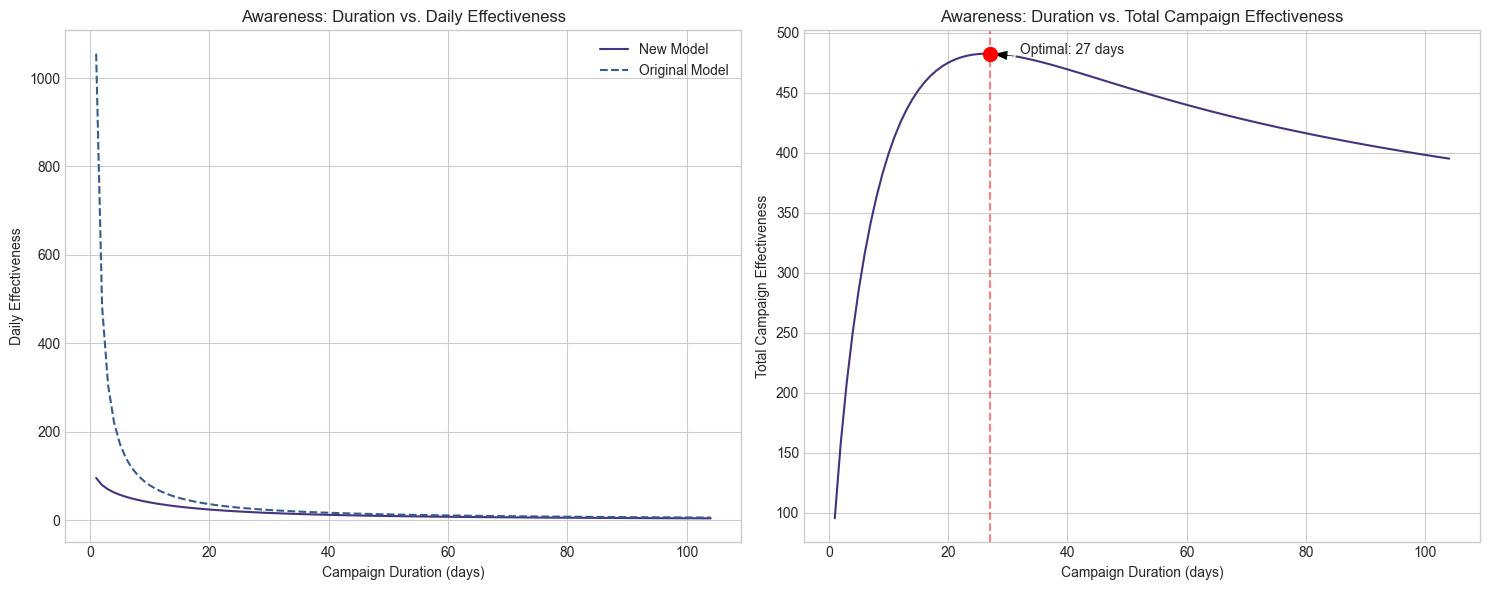

2025-05-05 15:50:15,764 - INFO - Best parameters: power=-0.2000, scale=1000.00, saturation=10.00
2025-05-05 15:50:15,764 - INFO - Optimal duration: 27 days
2025-05-05 15:50:15,764 - INFO - Performing grid search for conversion campaigns...
2025-05-05 15:50:15,764 - INFO - Testing 150 parameter combinations...
2025-05-05 15:50:15,769 - INFO - Progress: 0/150 combinations tested
2025-05-05 15:50:15,779 - INFO - Progress: 20/150 combinations tested
2025-05-05 15:50:15,789 - INFO - Progress: 40/150 combinations tested
2025-05-05 15:50:15,804 - INFO - Progress: 60/150 combinations tested
2025-05-05 15:50:15,814 - INFO - Progress: 80/150 combinations tested
2025-05-05 15:50:15,824 - INFO - Progress: 100/150 combinations tested
2025-05-05 15:50:15,829 - INFO - Progress: 120/150 combinations tested
2025-05-05 15:50:15,839 - INFO - Progress: 140/150 combinations tested



Step 2: Performing grid search for conversion campaigns...


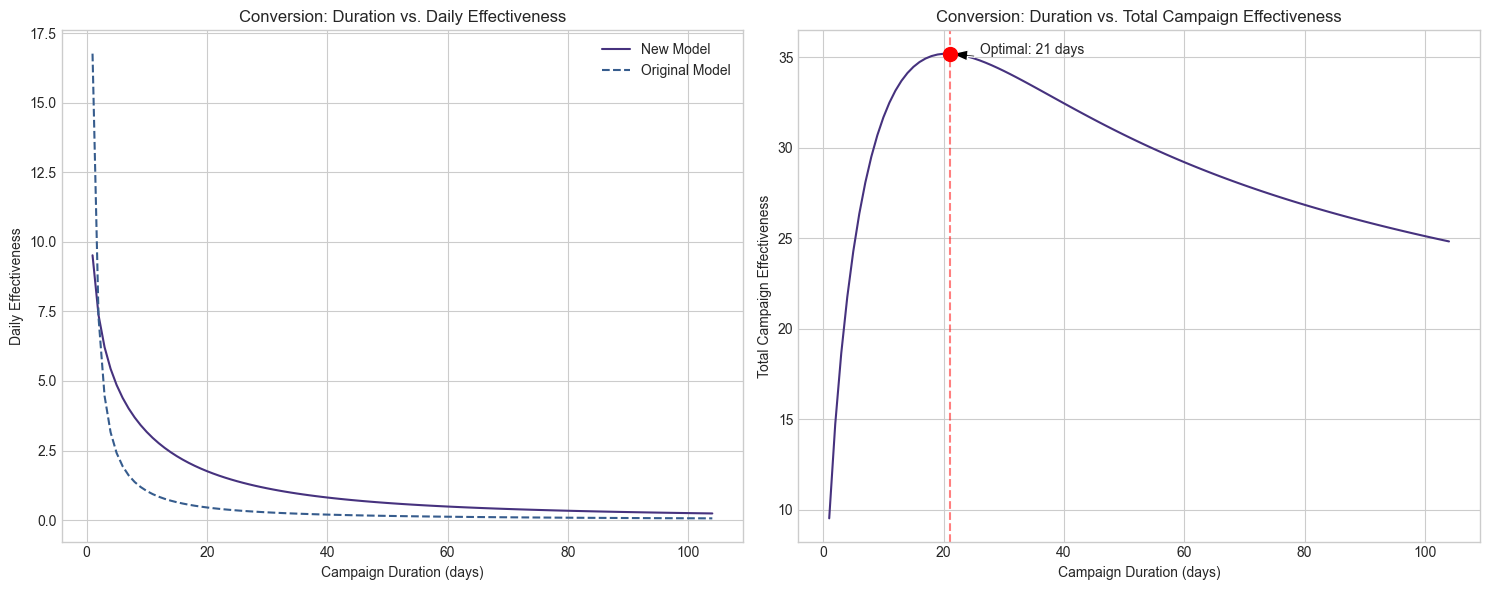

2025-05-05 15:50:16,164 - INFO - Best parameters: power=-0.3000, scale=100.00, saturation=10.00
2025-05-05 15:50:16,164 - INFO - Optimal duration: 21 days
2025-05-05 15:50:16,164 - INFO - Starting optimization for awareness campaign on facebook with budget $1000



Best parameters for awareness campaigns:
Power: -0.19999999999999998
Scale: 1000.0
Saturation: 10.0
Optimal duration: 27 days

Best parameters for conversion campaigns:
Power: -0.3
Scale: 100.0
Saturation: 10.0
Optimal duration: 21 days

Step 3: Optimizing awareness campaign...
Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -37284.517        9 0.005
NLP0012I 
              Nu

2025-05-05 15:50:16,244 - INFO - Optimization completed in 0.08 seconds
2025-05-05 15:50:16,244 - INFO - Optimal duration: 31 days, Daily media cost: $32.26



 OPTIMIZATION METRICS REPORT - AWARENESS CAMPAIGN 

1. SOLVER PERFORMANCE
------------------------------------------------------------
Solver Time:              0.0797 seconds
Solver Status:            ok
Termination Condition:    optimal

2. MODEL PARAMETERS
------------------------------------------------------------
Diminishing Returns Power:      -0.2000
Diminishing Returns Scale:      1000.00
Diminishing Returns Saturation: 10.00

3. MODEL ACCURACY
------------------------------------------------------------
Linear Model Impressions:           74096.76
Diminishing Returns Impressions:    1148540.20
Prediction Error:                1450.05%

4. OPTIMIZATION RESULTS
------------------------------------------------------------
Platform:                 facebook
Budget:                   $1000.00
Optimal Duration:         31 days
Optimal Daily Media Cost: $32.26
Total Cost:               $1000.00
Estimated Impressions:    1148540
CPM:                     $0.87


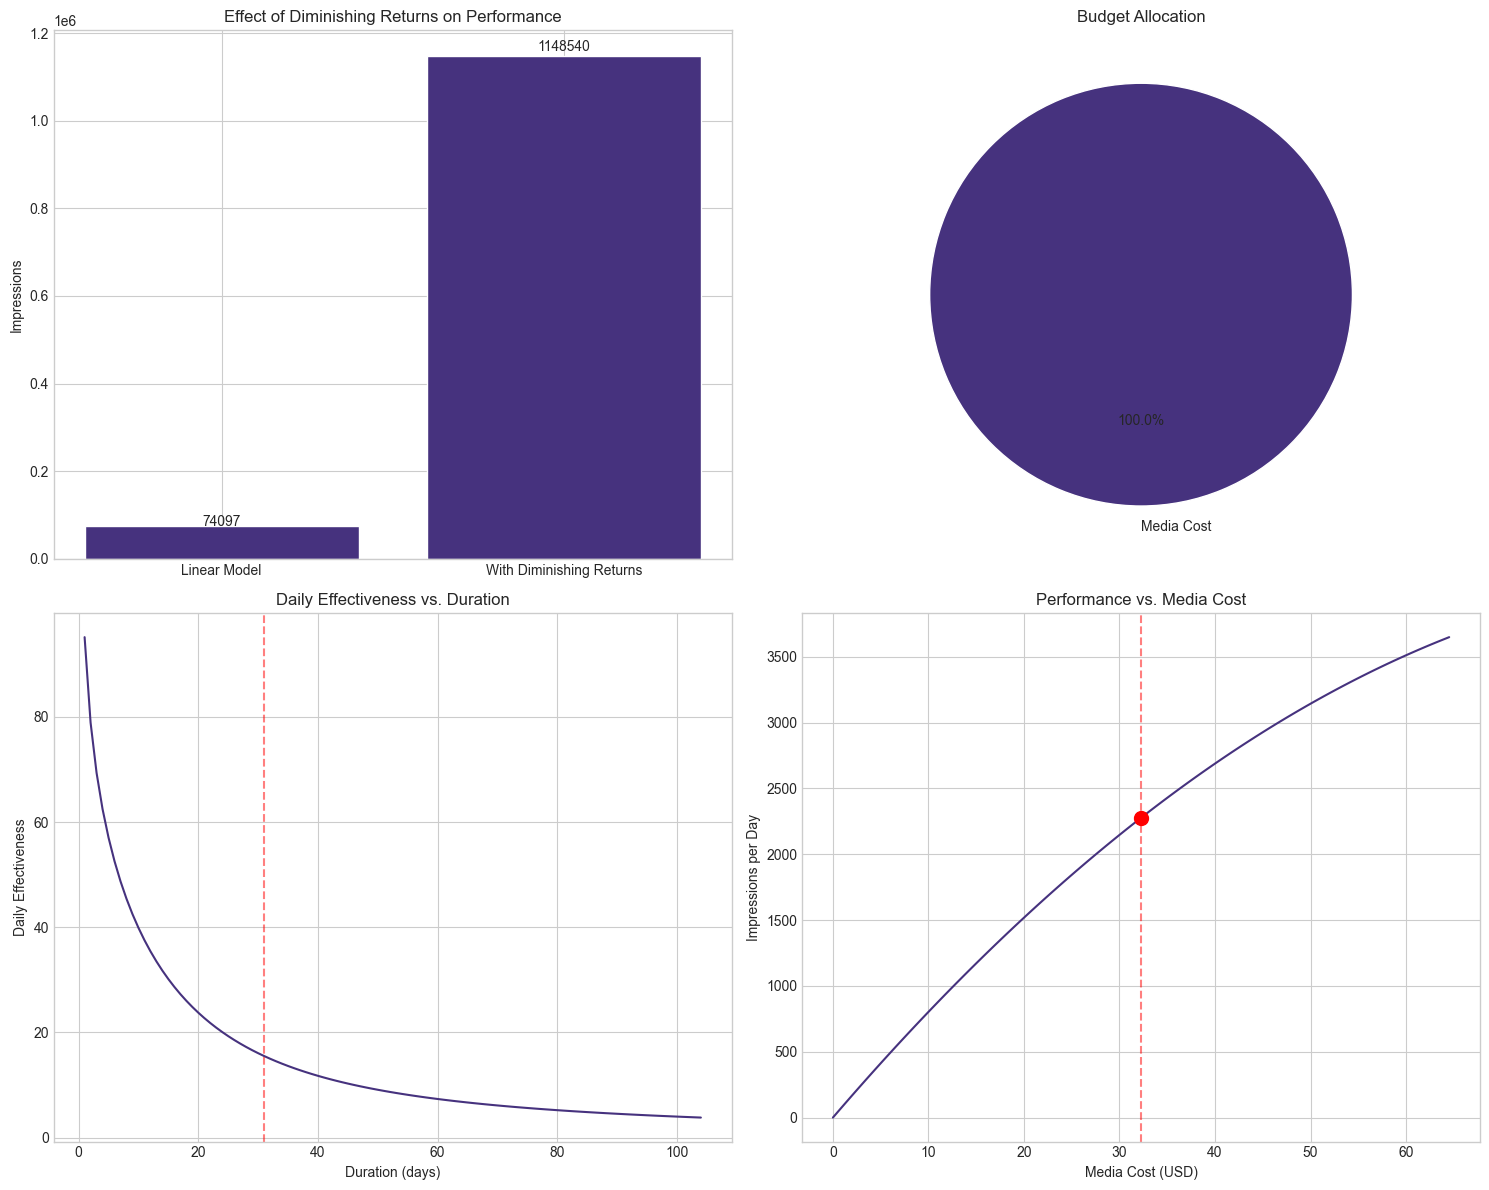

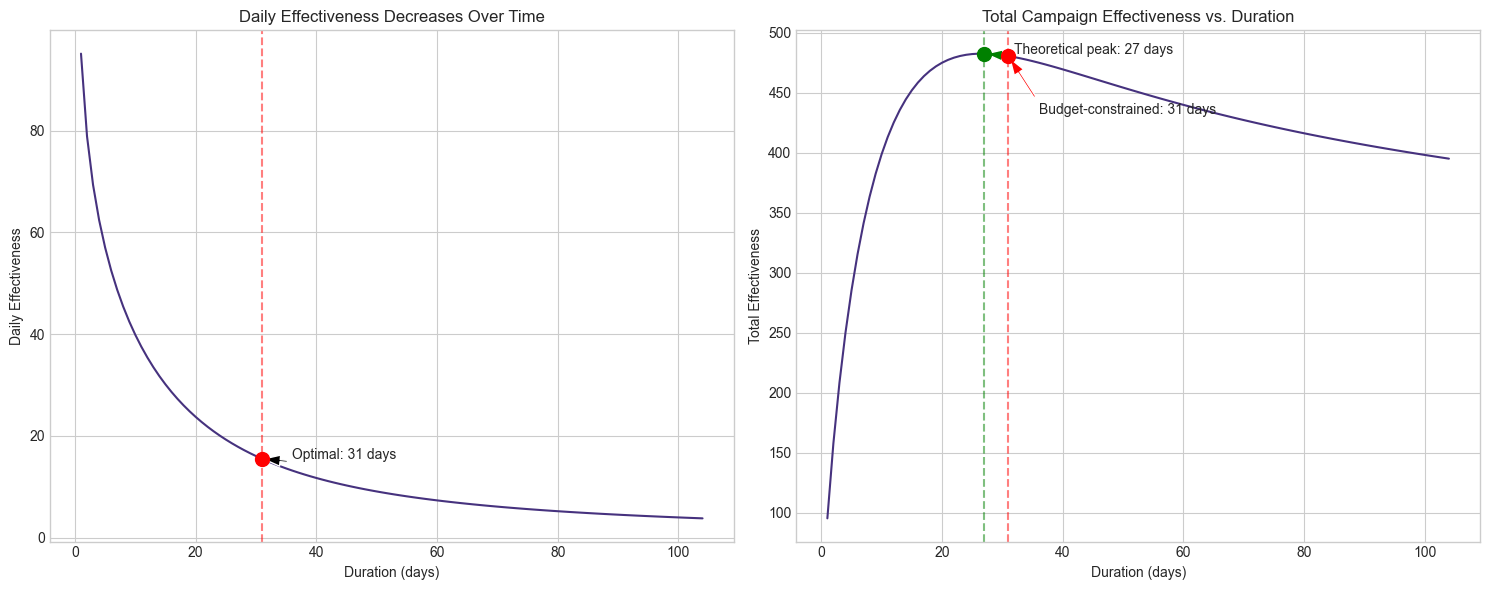

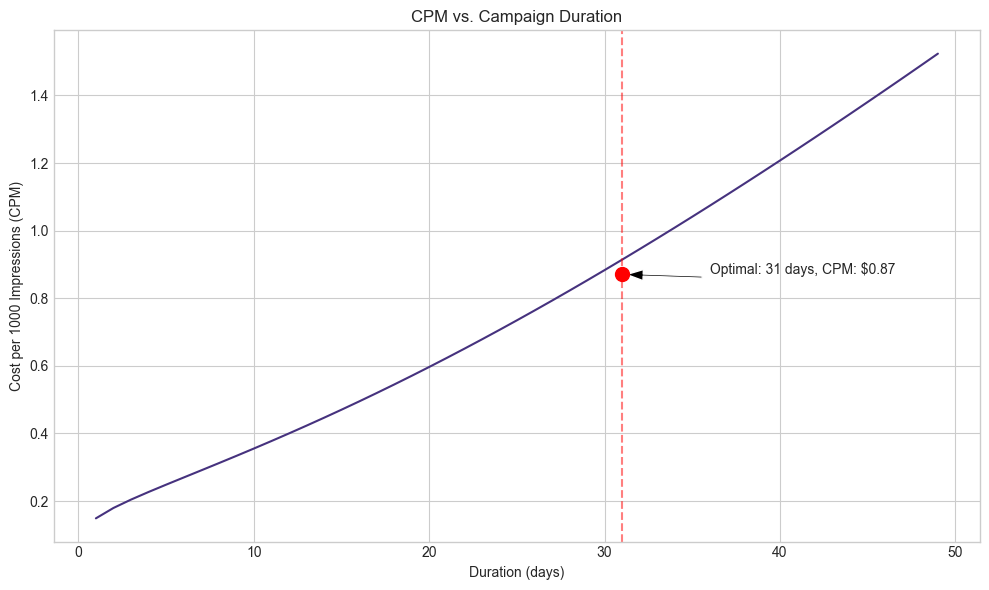

2025-05-05 15:50:18,045 - INFO - Starting optimization for conversion campaign on google with budget $1500



Awareness Campaign Optimization Summary:
campaign_goal: awareness
platform: facebook
budget: 1000
duration: 31
media_cost: 32.25806483870957
total_cost: 1000.0000099999968
impressions: 1148540.1960506316
cpm: 0.870670450575953

Step 4: Optimizing conversion campaign...
Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -1124.7031        9 0.01
NLP0012I 
              Num      Sta

2025-05-05 15:50:18,184 - INFO - Optimization completed in 0.14 seconds
2025-05-05 15:50:18,184 - INFO - Optimal duration: 43 days, Daily media cost: $34.88



 OPTIMIZATION METRICS REPORT - CONVERSION CAMPAIGN 

1. SOLVER PERFORMANCE
------------------------------------------------------------
Solver Time:              0.1390 seconds
Solver Status:            ok
Termination Condition:    optimal

2. MODEL PARAMETERS
------------------------------------------------------------
Diminishing Returns Power:      -0.3000
Diminishing Returns Scale:      100.00
Diminishing Returns Saturation: 10.00

3. MODEL ACCURACY
------------------------------------------------------------
Linear Model Clicks:           3475.94
Diminishing Returns Clicks:    2580.06
Prediction Error:                25.77%

4. OPTIMIZATION RESULTS
------------------------------------------------------------
Platform:                 google
Budget:                   $1500.00
Optimal Duration:         43 days
Optimal Daily Media Cost: $34.88
Total Cost:               $1500.00
Estimated Clicks:         2580
CPC:                     $0.58


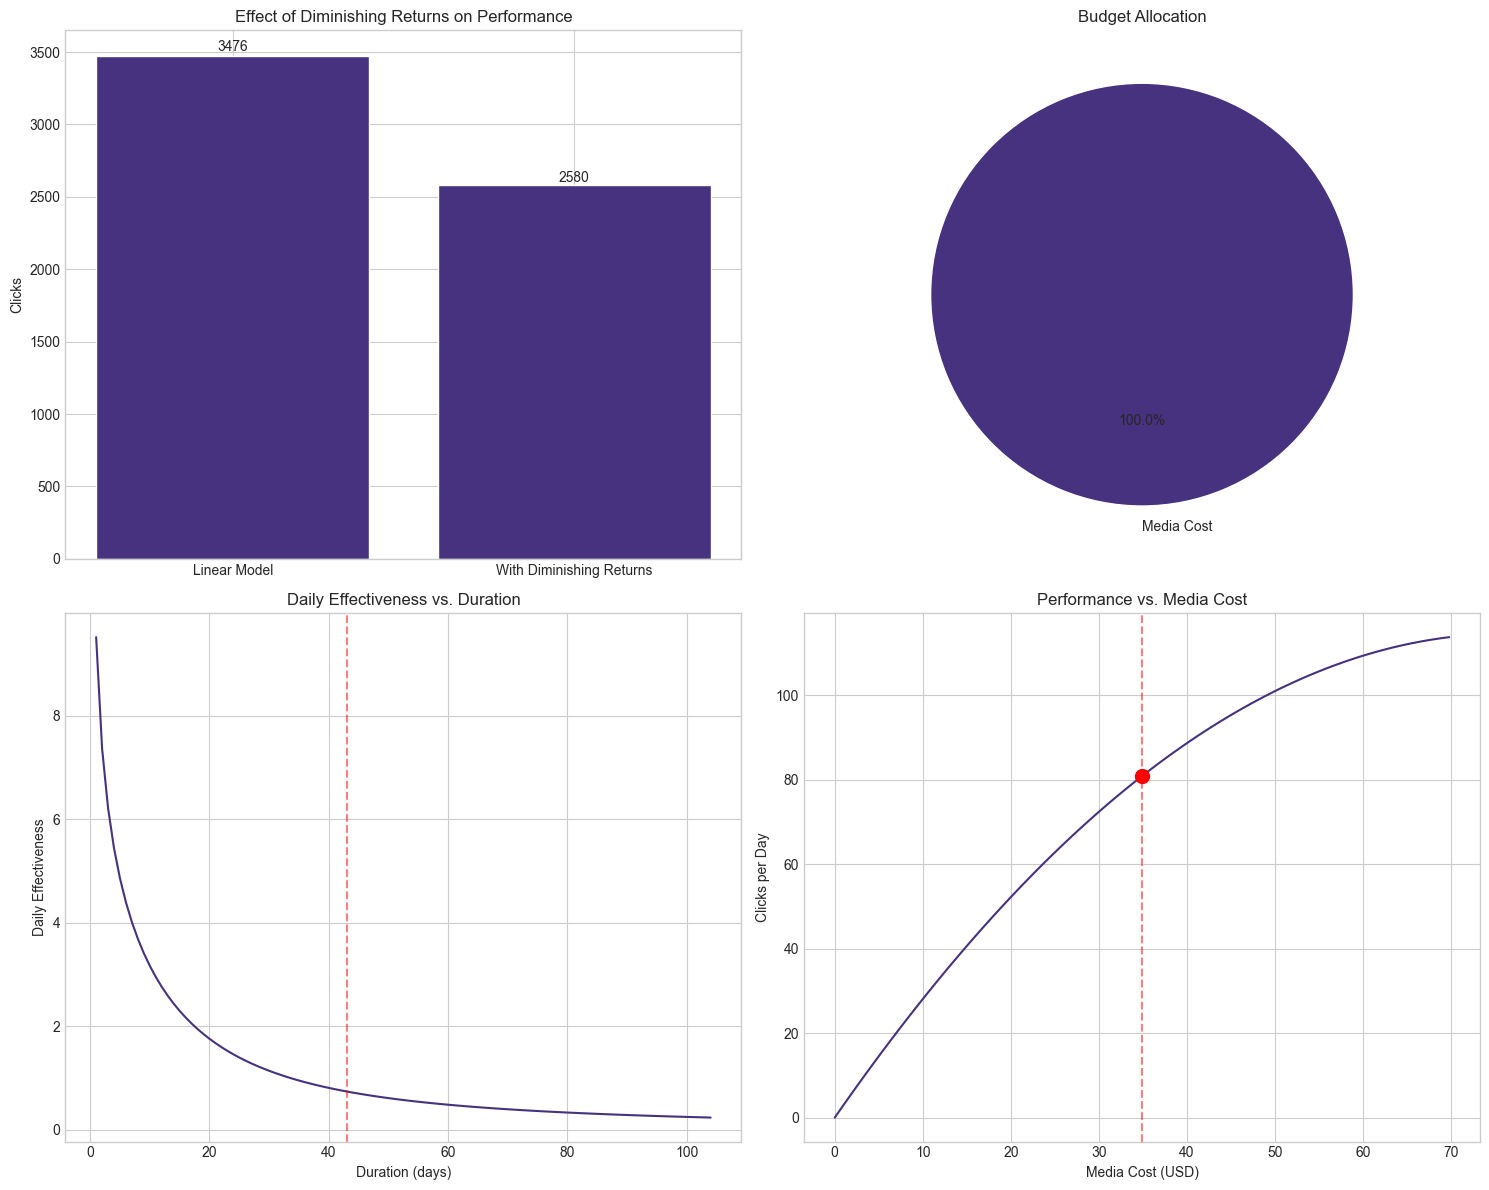

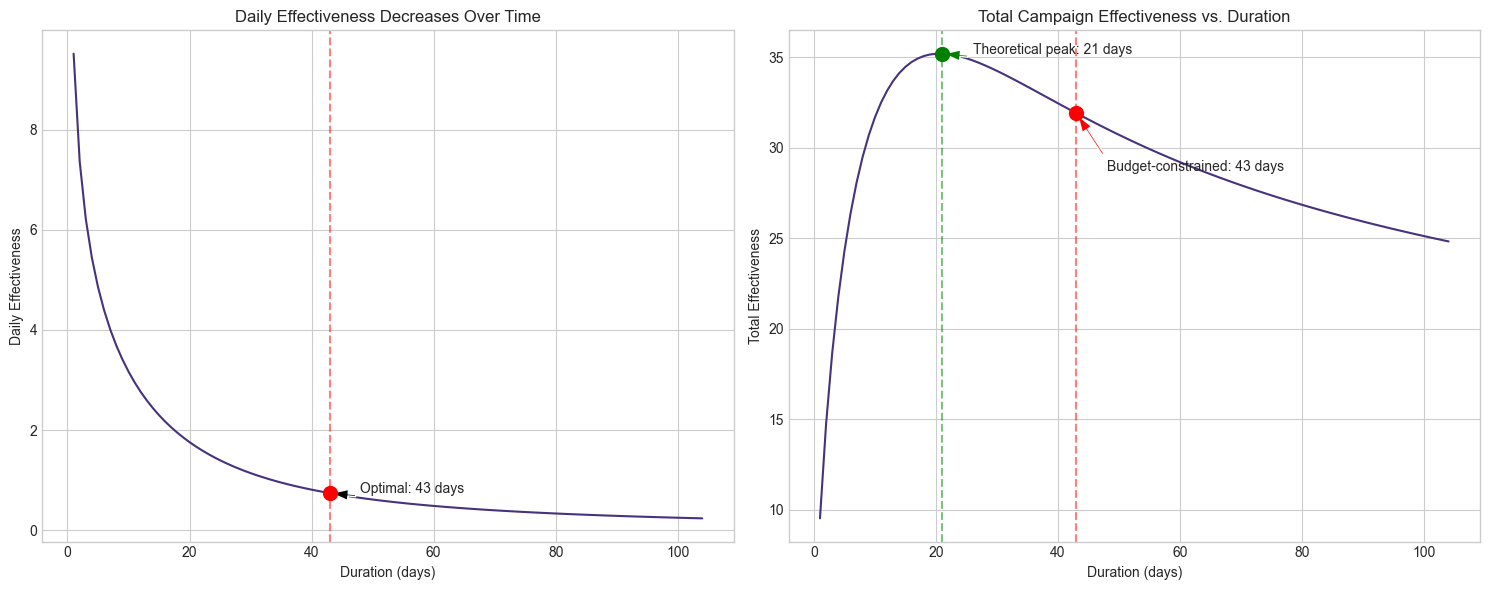

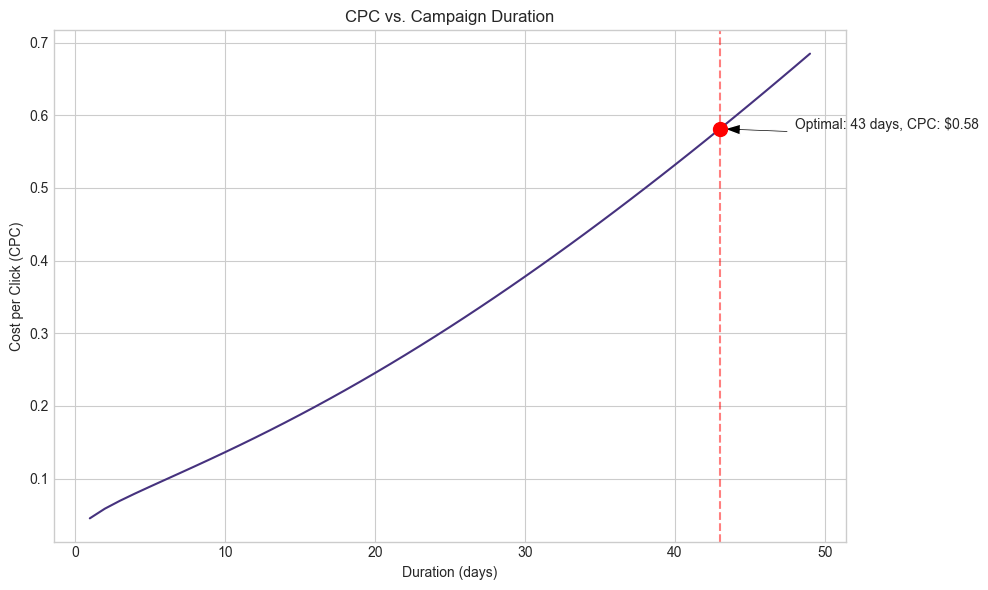


Conversion Campaign Optimization Summary:
campaign_goal: conversion
platform: google
budget: 1500
duration: 43
media_cost: 34.88372127906933
total_cost: 1500.000014999981
clicks: 2580.0593385538878
cpc: 0.5813819831914117


In [12]:
# Example usage with metrics report
if __name__ == "__main__":
    # Set the path to Bonmin solver
    bonmin_path = "C:\\Users\\USER\\Desktop\\Optimization stuff\\coin-module.mswin64\\ampl.mswin64\\bonmin.exe"

    # First, perform grid search to find optimal parameters for diminishing returns function
    print("Step 1: Performing grid search for awareness campaigns...")
    awareness_params = perform_grid_search('awareness')

    print("\nStep 2: Performing grid search for conversion campaigns...")
    conversion_params = perform_grid_search('conversion')

    # Store the best parameters
    best_awareness_params = awareness_params['best_params']
    best_conversion_params = conversion_params['best_params']

    print("\nBest parameters for awareness campaigns:")
    print(f"Power: {best_awareness_params['power']}")
    print(f"Scale: {best_awareness_params['scale']}")
    print(f"Saturation: {best_awareness_params['saturation']}")
    print(f"Optimal duration: {awareness_params['optimal_duration']} days")

    print("\nBest parameters for conversion campaigns:")
    print(f"Power: {best_conversion_params['power']}")
    print(f"Scale: {best_conversion_params['scale']}")
    print(f"Saturation: {best_conversion_params['saturation']}")
    print(f"Optimal duration: {conversion_params['optimal_duration']} days")

    # Example 1: Optimize an awareness campaign on Facebook with a budget of $1000
    print("\nStep 3: Optimizing awareness campaign...")
    awareness_result = optimize_campaign(
        campaign_goal='awareness',
        budget=1000,
        platform='facebook',
        bonmin_path=bonmin_path,
        dr_params=best_awareness_params
    )

    if awareness_result:
        # Generate detailed metrics report
        generate_optimization_metrics_report(awareness_result)

        # Print summary results
        print("\nAwareness Campaign Optimization Summary:")
        for key, value in awareness_result.items():
            if key not in ['performance_metrics', 'dr_params']:
                print(f"{key}: {value}")

    # Example 2: Optimize a conversion campaign on Google with a budget of $1500
    print("\nStep 4: Optimizing conversion campaign...")
    conversion_result = optimize_campaign(
        campaign_goal='conversion',
        budget=1500,
        platform='google',
        bonmin_path=bonmin_path,
        dr_params=best_conversion_params
    )

    if conversion_result:
        # Generate detailed metrics report
        generate_optimization_metrics_report(conversion_result)

        # Print summary results
        print("\nConversion Campaign Optimization Summary:")
        for key, value in conversion_result.items():
            if key not in ['performance_metrics', 'dr_params']:
                print(f"{key}: {value}")

Awareness campaign gridsearch

In [13]:
def recalibrate_awareness_parameters():
    """
    Perform a more detailed grid search to find better parameters for awareness campaigns,
    focusing on reducing the prediction error.

    Returns:
    --------
    dict
        Best parameters and visualization
    """
    logger.info("Recalibrating parameters for awareness campaigns...")

    # Define a wider range of parameters to search
    power_params = np.linspace(-0.45, -0.30, 10)     # More negative values for stronger diminishing returns
    scale_params = np.linspace(50, 80, 10)          # Much lower scale values to reduce the prediction error
    saturation_params = np.linspace(8, 15, 5)        # Range of saturation values

    # Duration range to evaluate
    duration_range = np.arange(1, 105)

    # Known relationship coefficients from data analysis for awareness
    reference_power = -0.1283
    reference_scale = np.exp(6.9614)

    # Calculate reference values (original model)
    reference_daily = reference_scale * (duration_range ** reference_power)
    reference_total = reference_daily * duration_range

    # Grid search
    best_params = None
    best_rmse = float('inf')
    best_peak_day = None
    results = []

    # Create parameter combinations
    param_combinations = list(itertools.product(power_params, scale_params, saturation_params))
    total_combinations = len(param_combinations)

    logger.info(f"Testing {total_combinations} parameter combinations...")

    for i, (power, scale, saturation) in enumerate(param_combinations):
        if i % 50 == 0:
            logger.info(f"Progress: {i}/{total_combinations} combinations tested")

        # Calculate effect for each duration using our formula
        daily_effect = np.array([diminishing_returns_effect(d, power, scale, saturation) / d for d in duration_range])
        total_effect = np.array([diminishing_returns_effect(d, power, scale, saturation) for d in duration_range])

        # Calculate root mean squared error between our model and reference
        rmse_daily = np.sqrt(np.mean((daily_effect - reference_daily/duration_range) ** 2))

        # Find peak day (where total effectiveness is maximized)
        peak_day = np.argmax(total_effect) + 1  # +1 because array is 0-indexed

        # We want a peak day between 10 and 40 for realistic campaigns
        # And we want a small prediction error when applied to a typical campaign

        # Calculate prediction error for a typical campaign (30 days, $30/day)
        typical_duration = 30
        typical_media_cost = 30

        # Media cost polynomial for impressions
        media_cost_poly_a = -0.4346
        media_cost_poly_b = 84.5877

        # Media cost effect
        media_cost_effect = media_cost_poly_a * typical_media_cost**2 + media_cost_poly_b * typical_media_cost

        # Linear model (no diminishing returns)
        linear_impressions = media_cost_effect * typical_duration

        # Model with diminishing returns
        dr_effect = diminishing_returns_effect(typical_duration, power, scale, saturation)
        dr_impressions = media_cost_effect * dr_effect

        # Calculate prediction error
        prediction_error = abs(linear_impressions - dr_impressions) / linear_impressions * 100

        # Store results if the peak day is in our target range and prediction error is reasonable
        if 10 <= peak_day <= 40 and prediction_error <= 100:  # Much stricter error threshold
            results.append({
                'power': power,
                'scale': scale,
                'saturation': saturation,
                'rmse_daily': rmse_daily,
                'peak_day': peak_day,
                'prediction_error': prediction_error
            })

            # Update best parameters if this has a better balance of prediction error and RMSE
            # We prioritize lower prediction error but still consider RMSE
            if prediction_error < 50 and (best_params is None or rmse_daily < best_rmse):
                best_rmse = rmse_daily
                best_params = {'power': power, 'scale': scale, 'saturation': saturation}
                best_peak_day = peak_day
                best_prediction_error = prediction_error

    if not best_params:
        logger.warning("No parameter combination met our criteria. Using parameters with lowest prediction error.")

        # Find the parameters with the lowest prediction error
        min_error = float('inf')
        for i, (power, scale, saturation) in enumerate(param_combinations):
            # Calculate prediction error for a typical campaign
            typical_duration = 30
            typical_media_cost = 30

            # Media cost effect
            media_cost_effect = media_cost_poly_a * typical_media_cost**2 + media_cost_poly_b * typical_media_cost

            # Linear model (no diminishing returns)
            linear_impressions = media_cost_effect * typical_duration

            # Model with diminishing returns
            dr_effect = diminishing_returns_effect(typical_duration, power, scale, saturation)
            dr_impressions = media_cost_effect * dr_effect

            # Calculate prediction error
            prediction_error = abs(linear_impressions - dr_impressions) / linear_impressions * 100

            # Find peak day
            total_effect = np.array([diminishing_returns_effect(d, power, scale, saturation) for d in duration_range])
            peak_day = np.argmax(total_effect) + 1

            # Update if this has a lower prediction error and reasonable peak day
            if 7 <= peak_day <= 60 and prediction_error < min_error:
                min_error = prediction_error
                best_params = {'power': power, 'scale': scale, 'saturation': saturation}
                best_peak_day = peak_day
                best_prediction_error = prediction_error

    # Calculate with best params
    daily_effect = np.array([diminishing_returns_effect(d, best_params['power'], best_params['scale'], best_params['saturation']) / d for d in duration_range])
    total_effect = np.array([diminishing_returns_effect(d, best_params['power'], best_params['scale'], best_params['saturation']) for d in duration_range])

    # Visualize the results
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Daily effect
    ax[0].plot(duration_range, daily_effect, label='New Model')
    ax[0].plot(duration_range, reference_daily/duration_range, linestyle='--', label='Original Model')
    ax[0].set_title(f'Awareness: Duration vs. Daily Effectiveness')
    ax[0].set_xlabel('Campaign Duration (days)')
    ax[0].set_ylabel('Daily Effectiveness')
    ax[0].legend()

    # Total effect
    ax[1].plot(duration_range, total_effect)
    ax[1].scatter([best_peak_day], [total_effect[best_peak_day-1]], color='red', s=100, zorder=5)
    ax[1].axvline(x=best_peak_day, color='red', linestyle='--', alpha=0.5)
    ax[1].set_title(f'Awareness: Duration vs. Total Campaign Effectiveness')
    ax[1].set_xlabel('Campaign Duration (days)')
    ax[1].set_ylabel('Total Campaign Effectiveness')
    ax[1].annotate(f'Optimal: {best_peak_day} days',
                  xy=(best_peak_day, total_effect[best_peak_day-1]),
                  xytext=(best_peak_day + 5, total_effect[best_peak_day-1]),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                  fontsize=10)

    plt.tight_layout()
    plt.show()

    # Calculate prediction error for a typical campaign to verify
    typical_duration = 30
    typical_media_cost = 30

    # Media cost effect
    media_cost_effect = media_cost_poly_a * typical_media_cost**2 + media_cost_poly_b * typical_media_cost

    # Linear model (no diminishing returns)
    linear_impressions = media_cost_effect * typical_duration

    # Model with diminishing returns
    dr_effect = diminishing_returns_effect(typical_duration, best_params['power'], best_params['scale'], best_params['saturation'])
    dr_impressions = media_cost_effect * dr_effect

    # Calculate prediction error
    prediction_error = abs(linear_impressions - dr_impressions) / linear_impressions * 100

    logger.info(f"Best parameters: power={best_params['power']:.4f}, scale={best_params['scale']:.2f}, saturation={best_params['saturation']:.2f}")
    logger.info(f"Optimal duration: {best_peak_day} days")
    logger.info(f"Expected prediction error: {prediction_error:.2f}%")

    return {
        'best_params': best_params,
        'optimal_duration': best_peak_day,
        'prediction_error': prediction_error
    }



Main function

2025-05-05 15:50:19,750 - INFO - Recalibrating parameters for awareness campaigns...
2025-05-05 15:50:19,750 - INFO - Testing 500 parameter combinations...
2025-05-05 15:50:19,754 - INFO - Progress: 0/500 combinations tested


Recalibrating awareness campaign parameters...


2025-05-05 15:50:19,790 - INFO - Progress: 50/500 combinations tested
2025-05-05 15:50:19,821 - INFO - Progress: 100/500 combinations tested
2025-05-05 15:50:19,844 - INFO - Progress: 150/500 combinations tested
2025-05-05 15:50:19,874 - INFO - Progress: 200/500 combinations tested
2025-05-05 15:50:19,904 - INFO - Progress: 250/500 combinations tested
2025-05-05 15:50:19,934 - INFO - Progress: 300/500 combinations tested
2025-05-05 15:50:19,970 - INFO - Progress: 350/500 combinations tested
2025-05-05 15:50:20,014 - INFO - Progress: 400/500 combinations tested
2025-05-05 15:50:20,054 - INFO - Progress: 450/500 combinations tested


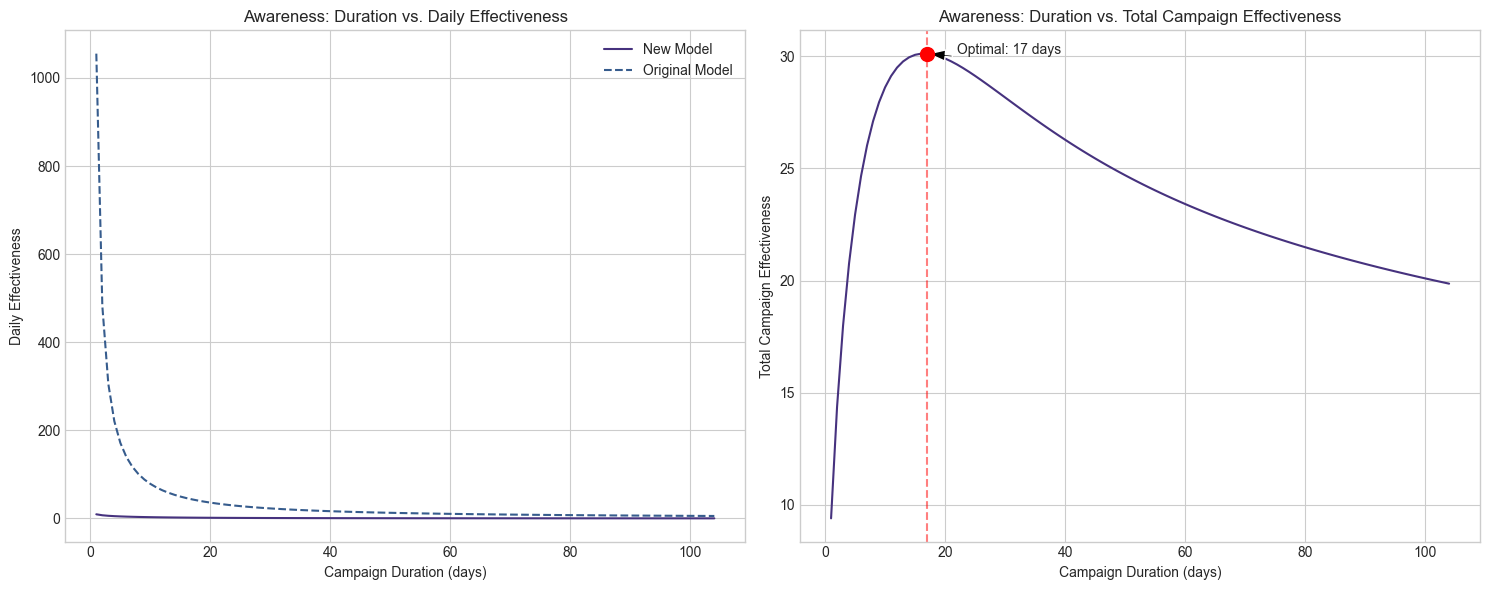

2025-05-05 15:50:20,524 - INFO - Best parameters: power=-0.3000, scale=80.00, saturation=8.00
2025-05-05 15:50:20,524 - INFO - Optimal duration: 17 days
2025-05-05 15:50:20,524 - INFO - Expected prediction error: 6.14%
2025-05-05 15:50:20,524 - INFO - Starting optimization for awareness campaign on facebook with budget $1000



Recalibrated parameters for awareness campaigns:
Power: -0.3
Scale: 80.0
Saturation: 8.0
Optimal duration: 17 days
Expected prediction error: 6.14%

Optimizing awareness campaign with recalibrated parameters...
Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: bonmin.algorithm=B-BB
bonmin.time_limit=600
bonmin.algorithm=B-BB
bonmin.time_limit=600


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -26932.197        9 0.01
NLP0012I 
              Num      Status      Obj             It       time                 Loca

2025-05-05 15:50:20,634 - INFO - Optimization completed in 0.11 seconds
2025-05-05 15:50:20,639 - INFO - Optimal duration: 22 days, Daily media cost: $45.45



 OPTIMIZATION METRICS REPORT - AWARENESS CAMPAIGN 

1. SOLVER PERFORMANCE
------------------------------------------------------------
Solver Time:              0.1099 seconds
Solver Status:            ok
Termination Condition:    optimal

2. MODEL PARAMETERS
------------------------------------------------------------
Diminishing Returns Power:      -0.3000
Diminishing Returns Scale:      80.00
Diminishing Returns Saturation: 8.00

3. MODEL ACCURACY
------------------------------------------------------------
Linear Model Impressions:           68074.81
Diminishing Returns Impressions:    91671.91
Prediction Error:                34.66%

4. OPTIMIZATION RESULTS
------------------------------------------------------------
Platform:                 facebook
Budget:                   $1000.00
Optimal Duration:         22 days
Optimal Daily Media Cost: $45.45
Total Cost:               $1000.00
Estimated Impressions:    91672
CPM:                     $10.91


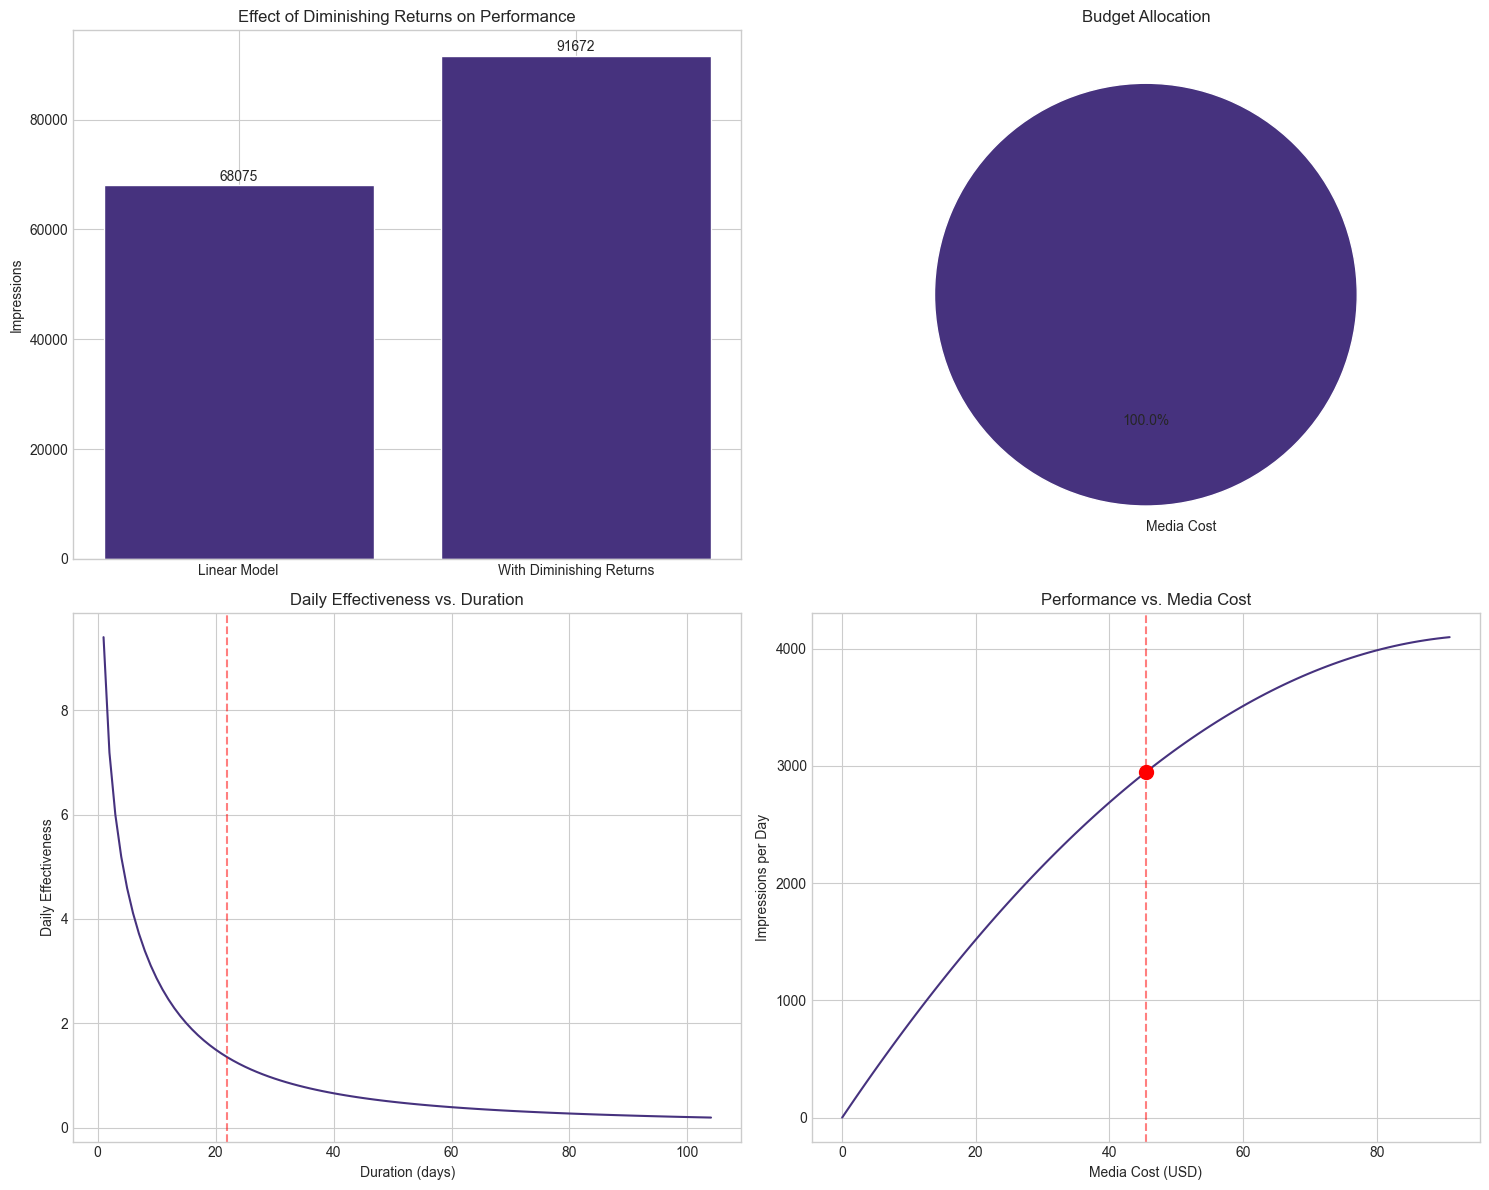

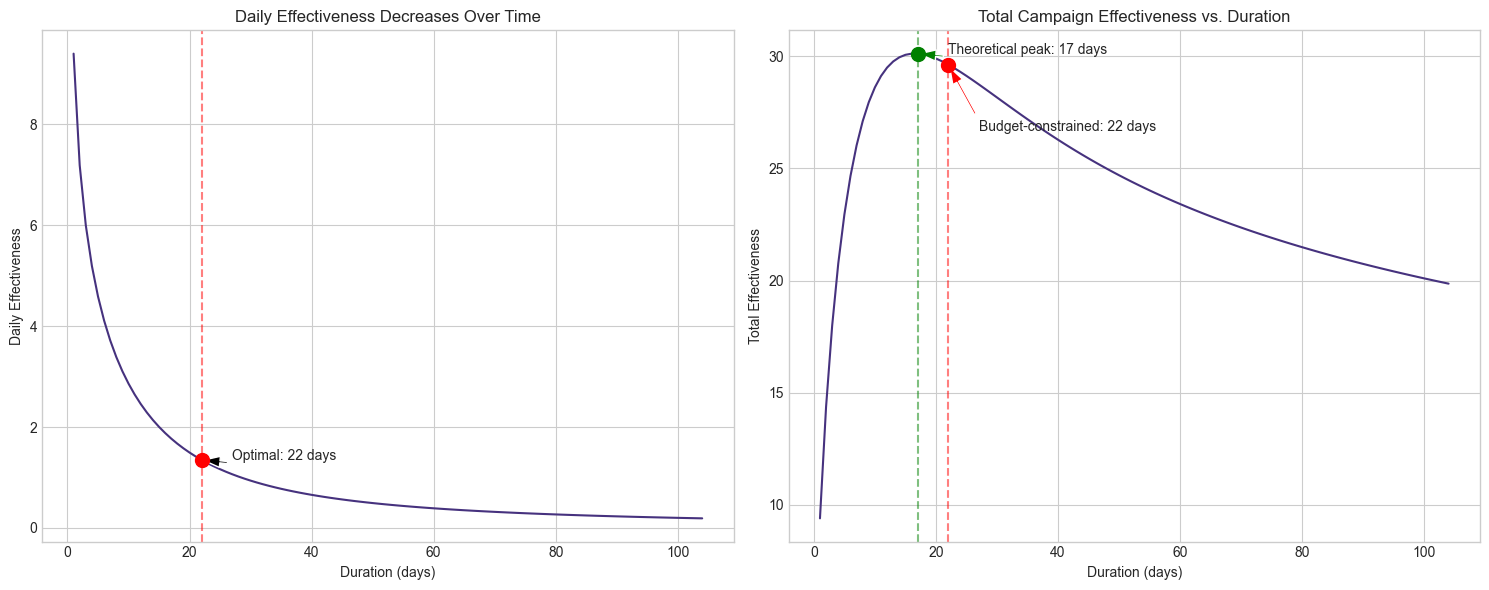

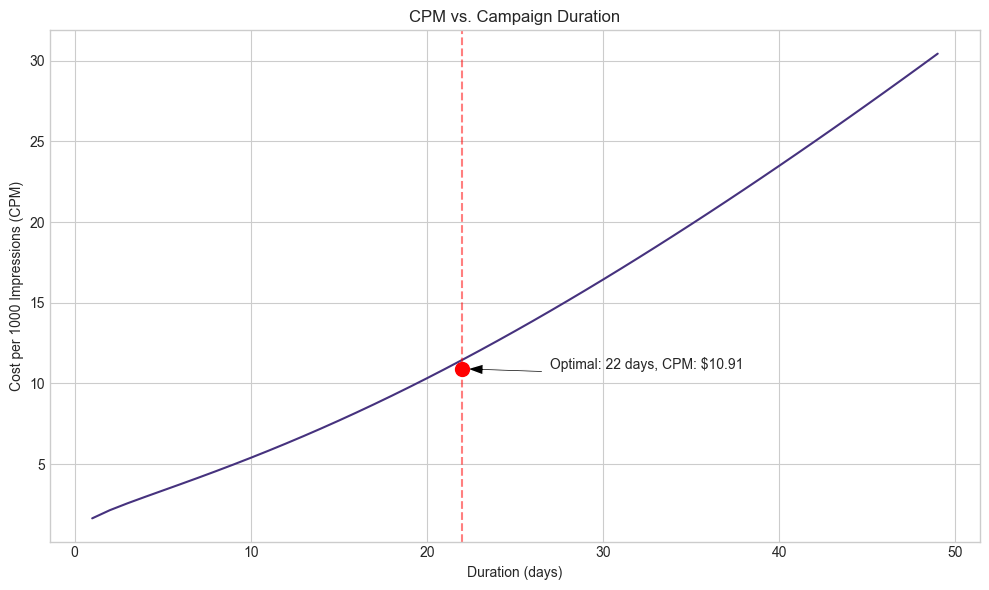


Awareness Campaign Optimization Summary:
campaign_goal: awareness
platform: facebook
budget: 1000
duration: 22
media_cost: 45.45454590909081
total_cost: 1000.0000099999978
impressions: 91671.90923791422
cpm: 10.908467144550446


In [14]:
# Main function
if __name__ == "__main__":
    # Set the path to Bonmin solver
    bonmin_path = "C:\\Users\\USER\\Desktop\\Optimization stuff\\coin-module.mswin64\\ampl.mswin64\\bonmin.exe"

    # Recalibrate awareness parameters
    print("Recalibrating awareness campaign parameters...")
    recalibrated_params = recalibrate_awareness_parameters()

    # Display the recalibrated parameters
    print("\nRecalibrated parameters for awareness campaigns:")
    print(f"Power: {recalibrated_params['best_params']['power']}")
    print(f"Scale: {recalibrated_params['best_params']['scale']}")
    print(f"Saturation: {recalibrated_params['best_params']['saturation']}")
    print(f"Optimal duration: {recalibrated_params['optimal_duration']} days")
    print(f"Expected prediction error: {recalibrated_params['prediction_error']:.2f}%")

    # Run optimization with recalibrated parameters
    print("\nOptimizing awareness campaign with recalibrated parameters...")
    awareness_result = optimize_campaign(
        campaign_goal='awareness',
        budget=1000,
        platform='facebook',
        bonmin_path=bonmin_path,
        dr_params=recalibrated_params['best_params']
    )

    if awareness_result:
        # Generate detailed metrics report
        generate_optimization_metrics_report(awareness_result)

        # Print summary results
        print("\nAwareness Campaign Optimization Summary:")
        for key, value in awareness_result.items():
            if key not in ['performance_metrics', 'dr_params']:
                print(f"{key}: {value}")